# Test galfit pipeline on COSMOS data and compare to van der wel + 2012
#### Revisit Jan 21/2020

data : http://arcoiris.ucolick.org/candels/data_access/Latest_Release.html , 
https://users.ugent.be/~avdrwel/research.html#candels

3DHST (F140W) data: https://3dhst.research.yale.edu/Data.php
catalog readme: http://monoceros.astro.yale.edu/RELEASE_V4.0/Photometry/COSMOS/cosmos_3dhst.v4.1.cats/cosmos_readme.v4.1.txt

All fluxes are normalized to an AB zeropoint of 25, such that: magAB = 25.0-2.5*log10(flux)

In [1]:
# https://github.com/Grillard/GalfitPyWrap may be useful for setting up inputs
import sys
# sys.path.insert(0,'/data/emiln/XLSSU122/analysis/galfit/GalfitPyWrap')
sys.path.insert(0,'/data/emiln/XLSSC122_GalPops/Analysis/Modules')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table, hstack, join
import pickle
import os
from __future__ import division
import fnmatch
import multiprocessing as mp
%matplotlib inline
%load_ext autoreload
%autoreload 2

/data/emiln/miniconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
gf.__file__

&#39;/data/emiln/XLSSC122_GalPops/Analysis/Modules/GalfitPyWrap/galfitwrap.py&#39;

## Load COSMOS morphology catalog

In [2]:
# Load cosmos catalog
cos_cat = '/data/emiln/XLSSU122/analysis/allfields_candels/vdwel/Downloads/cos_2epoch_wfc3_f125w_060mas_v1.0_galfit.cat'

cos_df = pd.read_csv(cos_cat,header=0,delim_whitespace=True,skiprows=[1])
cos_df2 = cos_df[cos_df.columns[:-1]]
cos_df2.columns = cos_df.columns[1:]
cos_df = cos_df2
cos_df_OG = cos_df
print len(cos_df)
# cos_df = cos_df[(cos_df['mag']<23) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now
# cos_df = cos_df[(cos_df['mag']>21) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now
cos_df = cos_df[(cos_df['mag']<21) & (cos_df['f']==0)] # Let's focus on objects brighter than mag 23 for now

cos_df = cos_df[(cos_df['dn']/cos_df['n'])<1] # Filter out objects with > 100% error
# f=0 are all "good fits" https://users.ugent.be/~avdrwel/data/readme_candels.txt
print len(cos_df)
cos_df.columns.values
print len(cos_df_OG)

38671
838
38671


In [3]:
cos_cat = 'cos_df_all_merged.csv'
cos_df = pd.read_csv(cos_cat)
cos_df_OG = cos_df

print len(cos_df_OG)
cos_df_OG.columns.values
# cos_df_OG

38671


array(['ID', 'IAU_designation', 'RA_x', 'DEC_x', 'APCOR', 'CFHT_uS_FLUX',
       'CFHT_uS_FLUXERR', 'CFHT_gS_FLUX', 'CFHT_gS_FLUXERR',
       'CFHT_rS_FLUX', 'CFHT_rS_FLUXERR', 'CFHT_iS_FLUX',
       'CFHT_iS_FLUXERR', 'CFHT_zS_FLUX', 'CFHT_zS_FLUXERR',
       'Subaru_B_FLUX', 'Subaru_B_FLUXERR', 'Subaru_gp_FLUX',
       'Subaru_gp_FLUXERR', 'Subaru_V_FLUX', 'Subaru_V_FLUXERR',
       'Subaru_rp_FLUX', 'Subaru_rp_FLUXERR', 'Subaru_ip_FLUX',
       'Subaru_ip_FLUXERR', 'Subaru_zp_FLUX', 'Subaru_zp_FLUXERR',
       'ACS_F606W_FLUX', 'ACS_F606W_FLUXERR', 'ACS_F814W_FLUX',
       'ACS_F814W_FLUXERR', 'WFC3_F125W_FLUX', 'WFC3_F125W_FLUXERR',
       'WFC3_F160W_FLUX', 'WFC3_F160W_FLUXERR', 'UltraVISTA_Y_FLUX',
       'UltraVISTA_Y_FLUXERR', 'UltraVISTA_J_FLUX',
       'UltraVISTA_J_FLUXERR', 'UltraVISTA_H_FLUX',
       'UltraVISTA_H_FLUXERR', 'UltraVISTA_Ks_FLUX',
       'UltraVISTA_Ks_FLUXERR', 'IRAC_Ch1_FLUX', 'IRAC_Ch1_FLUXERR',
       'IRAC_Ch2_FLUX', 'IRAC_Ch2_FLUXERR', 'IRAC_Ch3_FLUX',

In [4]:
cos_df_highz = pd.read_csv('cos_z2_thresh0p1_err0p2.csv')
print len(cos_df_highz)
cos_df_highz = cos_df_highz[cos_df_highz['f']==0] # Flag for good fit
print len(cos_df_highz)
cos_df_highz = cos_df_highz[cos_df_highz['F125W_Kron']<24]
print len(cos_df_highz)

194
156
156


In [252]:
# print len(cos_df_highz)
cos_df_highz.columns.values
print np.mean(cos_df_highz['dre']/cos_df_highz['re'])

0.0537163410295


In [253]:
# cos_df_highz
print cos_df_OG['F125W_Kron'].isnull().sum()

print cos_df_OG['F160W_Kron'].isnull().sum()

ttdf = cos_df_OG[cos_df_OG['F125W_Kron'].isnull() & cos_df_OG['F160W_Kron'].isnull()]
print len(ttdf)
ttdf[['F125W_Kron','F160W_Kron']]

1110
145
99


,F125W_Kron,F160W_Kron
481,NaN,NaN
518,NaN,NaN
918,NaN,NaN
931,NaN,NaN
961,NaN,NaN
2057,NaN,NaN
2233,NaN,NaN
2374,NaN,NaN
2642,NaN,NaN
3198,NaN,NaN


In [254]:
print len(cos_df)
cos_df = cos_df[cos_df['mag']<24]
print len(cos_df)
cos_df.columns.values

38671
9309


array(['ID', 'IAU_designation', 'RA_x', 'DEC_x', 'APCOR', 'CFHT_uS_FLUX',
       'CFHT_uS_FLUXERR', 'CFHT_gS_FLUX', 'CFHT_gS_FLUXERR',
       'CFHT_rS_FLUX', 'CFHT_rS_FLUXERR', 'CFHT_iS_FLUX',
       'CFHT_iS_FLUXERR', 'CFHT_zS_FLUX', 'CFHT_zS_FLUXERR',
       'Subaru_B_FLUX', 'Subaru_B_FLUXERR', 'Subaru_gp_FLUX',
       'Subaru_gp_FLUXERR', 'Subaru_V_FLUX', 'Subaru_V_FLUXERR',
       'Subaru_rp_FLUX', 'Subaru_rp_FLUXERR', 'Subaru_ip_FLUX',
       'Subaru_ip_FLUXERR', 'Subaru_zp_FLUX', 'Subaru_zp_FLUXERR',
       'ACS_F606W_FLUX', 'ACS_F606W_FLUXERR', 'ACS_F814W_FLUX',
       'ACS_F814W_FLUXERR', 'WFC3_F125W_FLUX', 'WFC3_F125W_FLUXERR',
       'WFC3_F160W_FLUX', 'WFC3_F160W_FLUXERR', 'UltraVISTA_Y_FLUX',
       'UltraVISTA_Y_FLUXERR', 'UltraVISTA_J_FLUX',
       'UltraVISTA_J_FLUXERR', 'UltraVISTA_H_FLUX',
       'UltraVISTA_H_FLUXERR', 'UltraVISTA_Ks_FLUX',
       'UltraVISTA_Ks_FLUXERR', 'IRAC_Ch1_FLUX', 'IRAC_Ch1_FLUXERR',
       'IRAC_Ch2_FLUX', 'IRAC_Ch2_FLUXERR', 'IRAC_Ch3_FLUX',

In [255]:
# Load cosmos fits images

cos_file = '/data/emiln/XLSSU122/analysis/cosmos/hlsp_candels_hst_wfc3_cos-tot_f125w_v1.0_drz.fits'
cos_hdulist = fits.open(cos_file)
full_wcs = wcs.WCS(cos_hdulist[0].header)
df = cos_df_OG
df['X'] = full_wcs.wcs_world2pix(df['RA'],df['DEC'], 1)[0]
df['Y'] = full_wcs.wcs_world2pix(df['RA'],df['DEC'], 1)[1]
# df['ID'] = int(df['NUMBER'])
# print df['NUMBER']

cos_df['X'] = full_wcs.wcs_world2pix(cos_df['RA'],cos_df['DEC'], 1)[0]
cos_df['Y'] = full_wcs.wcs_world2pix(cos_df['RA'],cos_df['DEC'], 1)[1]

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


/home/emiln/.local/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/emiln/.local/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8.0


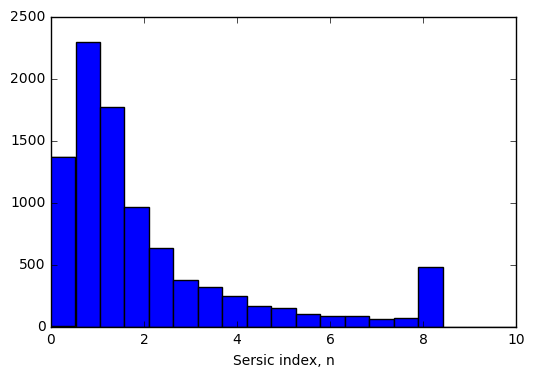

In [256]:
plt.hist(cos_df['n'],bins=np.linspace(0,10,20))
plt.xlabel('Sersic index, n')
print np.max(cos_df['n'])

Looks like a hardcap of 8 was applied to sersic indices

## Load Functions and Data
Run on CPS + Sigma_CPS

In [5]:
ncpu = mp.cpu_count()
print ncpu

8


In [6]:
def run_galfit_cosmos_parallel(row1,OG_df=cos_df_OG,zp=26,width=90,HLwidth=False,PSFf=1,use_psf=True,\
                               timeout=300,verb=False,psf_file='tinytim_psf.fits',\
                               sigma_file='/sigma_meanexp_cutout.fits',cutout_file='/cutout.fits',\
                               save_name='rmssigmameanexp_w180_TESTING',\
                              PA_INIT=45, AR_INIT=0.5, MAG_INIT=21,DYNMAG=False, convbox='100 100',
                              constr='none',cutout_width = 200, badmask='none', MAGFIT=False, mag_thresh=5,
                               sky='Default',skyINIT=0, N=0):
#     cutout_width = 200 # ALWAYS KEEP THE SAME, PHYSICAL SIZE OF CUTOUTS FROM DATA_PREP
#     N = 0 # Extra width to search for neighbours in?
#     mag_thresh = 4 # Neighbours only fit if less than mag_thresh fainter than primary
    
    df = OG_df
    r = row1
    ra = r.RA
    dec = r.DEC
    ID = int(r['NUMBER'])
    if badmask != 'none':
        print "Using bad pixel mask..."
        badmask = tdir+badmask
    if DYNMAG:
        MAG_INIT=np.round(r.F125W_Kron,decimals=2)
        og_mag=MAG_INIT
        print "Initializing",str(ID),"with F125W Kron magnitude:", MAG_INIT
    pixcrd = full_wcs.wcs_world2pix(ra,dec, 1)
    print pixcrd
    X = int(pixcrd[0])
    Y = int(pixcrd[1])
    
#     ids_all.append(ID)
    CX = cutout_width
    CY = cutout_width
    
    if MAGFIT:
        magf = 1
    else:
        magf = 0

    print "ID", ID
    print "RA:",ra
    print "DEC:",dec
    print "Initial X:", X
    print "Initial Y:", Y
    print "Cutout X:", CX 
    print "Cutout Y:", CY
    print "Cutout width:", cutout_width

    tdir = '/data/emiln/XLSSU122/analysis/cosmos/galfit_results/'+str(ID)
    
    model=[{
    0: 'sersic',              #  object type
    1: str(CX)+' '+str(CY)+' 1 1', #  position x, y
    3: str(MAG_INIT)+' '+str(magf),            #  Integrated magnitude   
    4: '10 1',            #  R_e (half-light radius)   [pix]
    5: '4 1',            #  Sersic index n (de Vaucouleurs n=4) 
    9: str(AR_INIT)+' 1',            #  axis ratio (b/a)  
    10: str(PA_INIT)+' 1',         #  position angle (PA) [deg: Up=0, Left=90]
    'Z': 0                   #  output option (0 = resid., 1 = Don't subtract) 
    }]

    if HLwidth == False:
        bounds = [CX-width,CX+width,CY-width,CY+width]
        bounds2 = [X-width,X+width,Y-width,Y+width]
        print "Cutoutwidth (pixels):", width*2
        print "Cutoutwidth (arcsec):", width*2*0.06
    else: 
        width = int(np.ceil(HLwidth*r.HLR))
        bounds = [CX-width,CX+width,CY-width,CY+width]
        bounds2 = [X-width,X+width,Y-width,Y+width]
        print "Cutoutwidth (pixels) for ID",str(ID),":", width*2
        print "Cutoutwidth (arcsec) for ID",str(ID),":", width*2*0.06
        
    print "Bounds:", bounds

    # Find neighbours in full DF
    # Neighbour check needs to be done on original fits image / catalog
    ndf = df[(df['X']>(bounds2[0]-N)) & (df['X']<(bounds2[1]+N)) & (df['Y']>(bounds2[2]-N)) & (df['Y']<(bounds2[3]+N))
             & (df['NUMBER']!=ID)]

    print len(ndf),"NEIGHBOURS FOUND"

    print "Adding additional model components for neighbours..."
    for row in ndf.iterrows():
        r = row[1]
        NX = r.X - X + cutout_width
        NY = r.Y - Y + cutout_width
        if DYNMAG:
            MAG_INIT=np.round(r.F125W_Kron,decimals=2)
            if np.isnan(MAG_INIT):
                MAG_INIT=og_mag # Initialize with MAG of primary target
                print "***NEIGHBOUR MAG NOT CATALOGED***"
            print "NEIGHBOUR initialized with F125W Kron magnitude:", MAG_INIT
            if MAG_INIT > og_mag+mag_thresh:
                print "Neighbour mag too faint, not being fit"
                continue # If mag is too faint, do not fit this object (Should eventually mask these)
                
        seqnr = int(r['NUMBER'])
        model.append({
                0: 'sersic',              #  object type
                1: str(NX)+' '+str(NY)+' 1 1', #  position x, y
                3: str(MAG_INIT)+' '+str(magf),            #  Integrated magnitude   
                4: '10 1',            #  R_e (half-light radius)   [pix]
                5: '4 1',            #  Sersic index n (de Vaucouleurs n=4) 
                9: str(AR_INIT)+' 1',            #  axis ratio (b/a)  
                10: str(PA_INIT)+' 1',         #  position angle (PA) [deg: Up=0, Left=90]
                'Z': 0                   #  output option (0 = resid., 1 = Don't subtract) 
                })


    if use_psf:
        print "Using PSF"
        O=gf.CreateFile(tdir+cutout_file, bounds, model,fout=tdir+'/input.feedme',\
                        Pimg=psf_file, Simg=tdir+sigma_file, ZP=zp, scale='0.06 0.06',PSFf=PSFf, convbox=convbox,
                       constr=constr, badmask=badmask, sky=sky,skyINIT=skyINIT)
        # convbox should be larger than PSF. f125_400 psf is (166,166)
    else:
        O=gf.CreateFile(tdir+cutout_file, bounds, model,fout=tdir+'/input.feedme',\
                        Simg=tdir+sigma_file, ZP=zp, scale='0.06 0.06', PSFf=PSFf, convbox=convbox, constr=constr,
                       badmask=badmask,sky=sky,skyINIT=skyINIT)

    p,oimg,mods,EV,chi2nu=gf.rungalfit(tdir+'/input.feedme',verb=verb, timeout=timeout)
    if EV==124: print "***PROCESS TIMEOUT***"
    bad_result = False
    print '****',ID,'****'
    try: 
        os.rename('out.fits',tdir+'/out_'+save_name+'.fits')
        os.rename('fit.log',tdir+'/fit_'+save_name+'.log')
        os.rename('galfit.01',tdir+'/galfit_'+save_name+'.01')
    except:
        print "***",ID,"Fit failed at GALFIT level***"
        

    try:
#         print "start try"
        print mods
        re_all = mods[0]['1_RE'].split(' ')
        ar_all = mods[0]['1_AR'].split(' ')
        n_all = mods[0]['1_N'].split(' ')
        m_all = mods[0]['1_MAG'].split(' ')
        s_all = mods[-1][str(len(mods))+'_SKY'].split(' ')
#         print "split('') complete"
        re_val = re_all[0].split('*')
        re_err_val = re_all[2].split('*')
        ar_val = ar_all[0].split('*')
        ar_err_val = ar_all[2].split('*')
        m_val = m_all[0].split('*')
        m_err_val = m_all[2].split('*')
        n_val = n_all[0].split('*')
        n_err_val = n_all[2].split('*')
        s_val = s_all[0].split('*')
        s_err_val = s_all[2].split('*')
#         print "split('*') complete"
        
        print re_val
        print re_err_val
        print m_val
        print m_err_val
        print ar_val
        print ar_err_val
        print s_val
        print s_err_val

        if len(re_val)>1:
#             EV+=2**2
            print 'ID',str(ID),'len(re_val)>1', len(re_val)>1

        if len(ar_val)>1:
#             EV+=2**3
            print 'ID',str(ID),'len(ar_val)>1', len(ar_val)>1

        if len(n_val)>1:
#             EV+=2**4
            print 'ID',str(ID),'len(n_val)>1', len(n_val)>1

        if len(m_val)>1:
#             EV+=2**5
            print 'ID',str(ID),'len(m_val)>1', len(m_val)>1
            
        if len(s_val)>1:
#             EV+=2**5
            print 'ID',str(ID),'len(s_val)>1', len(s_val)>1
            
#         print "EV updated for *"
        
        
#         print 'int(np.ceil(len(re_val)/2.)-1)', int(np.ceil(len(re_val)/2.)-1)
        re = float(re_val[int(np.ceil(len(re_val)/2.)-1)])
#         print 're', re
        
#         print 'int(np.ceil(len(re_err_val)/2.)-1)', int(np.ceil(len(re_err_val)/2.)-1)
        re_err = float(re_err_val[int(np.ceil(len(re_err_val)/2.)-1)])
#         print 're_err', re_err
        
#         print int(np.ceil(len(ar_val)/2.)-1)
        ar = float(ar_val[int(np.ceil(len(ar_val)/2.)-1)])
#         print ar
        ar_err = float(ar_err_val[int(np.ceil(len(ar_err_val)/2.)-1)])
#         print ar_err
        n = float(n_val[int(np.ceil(len(n_val)/2.)-1)])
#         print n
        n_err = float(n_err_val[int(np.ceil(len(n_err_val)/2.)-1)])
#         print n_err
        m = float(m_val[int(np.ceil(len(m_val)/2.)-1)])
#         print m
        m_err = float(m_err_val[int(np.ceil(len(m_err_val)/2.)-1)])
    
        s = float(s_val[int(np.ceil(len(s_val)/2.)-1)])
        s_err = float(s_err_val[int(np.ceil(len(s_err_val)/2.)-1)])

                       
    except:
        print "EXCEPTION"
        re_all = [-99,-99,-99]
        ar_all = re_all
        n_all = re_all
        m_all = re_all
        s_all = re_all
        re = float(re_all[0])
        re_err = float(re_all[2])
        ar = float(ar_all[0])
        ar_err = float(ar_all[2])
        n = float(n_all[0])
        n_err = float(n_all[2])
        m = float(m_all[0])
        m_err = float(m_all[2])
        s = float(s_all[0])
        s_err = float(s_all[2])
        EV+=999

    return ID,ra,dec, re, ar, n, m, s, chi2nu, EV

In [7]:
def showme3(oimg,fignum=None):
    vm = np.percentile(oimg[1].data,99)
#     print vm
    
    plt.figure(fignum)
    plt.subplot(131)
    plt.imshow(oimg[1].data,interpolation='none',cmap='viridis',vmin=1e-4,vmax=vm)
    plt.subplot(132)
    plt.imshow(oimg[2].data,interpolation='none',cmap='viridis',vmin=1e-4,vmax=vm)
    plt.subplot(133)
    plt.imshow(oimg[3].data,interpolation='none',cmap='viridis',vmin=1e-4,vmax=vm)

In [8]:
def plot_by_ID(ID,save_name=None,cos_df=cos_df):
    if not save_name:
        print 'provide a save_name...'
        return
    tdir = '/data/emiln/XLSSU122/analysis/cosmos/galfit_results/'+str(ID)
    
#     ttdf = pd.read_csv('COSMOS_test_galfit_results_'+save_name+'.csv')
    ttdf = pd.read_csv('results/'+save_name+'.csv')
    print 'ID:',ID
    print 'ttdf[ID]',ttdf['ID']
    print ttdf[ttdf['ID'] == ID]
#     print ID
    try: 
        oimg = fits.open(tdir+'/out_'+save_name+'.fits')
        showme3(oimg)
    except:
        print "No model fit found. Plotting raw image from /cutout.fits"
        try:
            oimg = fits.open(tdir+'/cutout.fits')
            vm = np.percentile(oimg[0].data,99)
            plt.figure()
            plt.subplot(131)
            plt.imshow(oimg[0].data,interpolation='none',cmap='viridis',vmin=1e-4,vmax=vm)
        except:
            print "No cutout.fits file found..."
            oimg = fits.open(tdir+'/data_cps.fits')
            vm = np.percentile(oimg[0].data,99)
            plt.figure(figsize=(5,5))
            plt.subplot()
            plt.imshow(oimg[0].data,interpolation='none',cmap='viridis',vmin=1e-4,vmax=vm)
        
    print '\n ***CATALOG PARAMS***'
    print cos_df[cos_df['NUMBER']==ID][['q','n','re']]
    plt.show()

In [24]:
def compare_df(galfit_file,catalog_df,sky=False):
    # Load fits and compare to published catalog
    df2 = pd.read_csv(galfit_file)
    len(df2[df2['n']==-99])
    df = df2[df2['n']!=-99]
    cos_df = catalog_df

    plt.hist(cos_df['n'],bins=np.linspace(0,10,20),alpha=0.5,color='blue', label='Catalog')
    plt.hist(df['n'],bins=np.linspace(0,10,20), alpha=0.5,color='red', label='Test')
    plt.xlabel('Sersic index, n')
    plt.legend()
    plt.show()
    print np.max(cos_df['n'])

    plt.hist(cos_df['re'],bins=np.linspace(0,6,30),alpha=0.5,color='blue', label='Catalog')
    plt.hist(df['re']*0.06,bins=np.linspace(0,6,30), alpha=0.5,color='red', label='Test')
    plt.xlabel('Effective radius (\'\')')
    plt.legend()
    plt.show()

    plt.hist(cos_df['q'],bins=np.linspace(0,1,20),alpha=0.5,color='blue', label='Catalog')
    plt.hist(df['ar'],bins=np.linspace(0,1,20), alpha=0.5,color='red', label='Test')
    plt.xlabel('Axis ratio, q')
    plt.legend()
    plt.show()
    
    mdf = df.merge(cos_df,left_on='ID',right_on='NUMBER',suffixes=('_M','_C'))
    
    print mdf.columns.values
    
    mdf['logn_M'] = np.log10(mdf['n_M'])
    mdf['logn_C'] = np.log10(mdf['n_C'])
    mdf['re_M'] = mdf['re_M']*0.06
    
    mdf['Delta_n'] = mdf['n_M'] - mdf['n_C'] 
    mdf['Delta_re'] = mdf['re_M'] - mdf['re_C']
    mdf['Delta_q'] = mdf['ar'] - mdf['q']
    mdf['Delta_mag'] = mdf['mag_M'] - mdf['mag_C'] 
    
    plt.scatter(mdf['F125W_Kron'],mdf['Delta_n'],facecolors='none',s=10,edgecolors='k')
    plt.ylabel(r'$\delta_n$')
    plt.xlabel(r'$F125W_{Kron}$')
    plt.ylim([-2,2])
    plt.show()
    
    plt.scatter(mdf['F125W_Kron'],mdf['Delta_re'],facecolors='none',s=10,edgecolors='k')
    plt.ylabel(r'$\delta_{re}$')
    plt.xlabel(r'$F125W_{Kron}$')
    plt.ylim([-0.5,0.5])
#     plt.yscale('log')
    plt.show()
    
    plt.scatter(mdf['F125W_Kron'],mdf['Delta_q'],facecolors='none',s=10,edgecolors='k')
    plt.ylabel(r'$\delta_q$')
    plt.xlabel(r'$F125W_{Kron}$')
    plt.ylim([-1,1])
    plt.show()
    
    plt.scatter(mdf['F125W_Kron'],mdf['Delta_mag'],facecolors='none',s=10,edgecolors='k')
    plt.ylabel(r'$\delta_{mag}$')
    plt.xlabel(r'$F125W_{Kron}$')
    plt.ylim([-1,1])
    plt.show()
    
#     plt.scatter(mdf['F125W_Kron'],mdf['Delta_n']/mdf['n_C'],facecolors='none',s=10,edgecolors='k')
#     plt.ylabel(r'$\delta_n/n_c$')
#     plt.xlabel(r'$F125W_{Kron}$')
#     plt.show()
    
    plt.scatter(mdf['n_M'],mdf['n_C'],facecolors='none',s=10,edgecolors='k')
    plt.plot([0,8],[0,8],'k--')
    plt.xlabel(r'Measured $n$')
    plt.ylabel(r'Catalog $n$')
    plt.xlim([0,8])
    plt.ylim([0,8])
    plt.show()
    
    print "Mean abs dex difference between measured and catalog n:", np.mean(np.sqrt((mdf['logn_M']-mdf['logn_C'])**2))
    print "Median abs dex difference between measured and catalog n:", np.median(np.sqrt((mdf['logn_M']-mdf['logn_C'])**2))
    print "Mean abs diff between measured and catalog n:", np.mean(abs(mdf['n_M']-mdf['n_C']))
    print "Median abs diff between measured and catalog n:", np.median(abs(mdf['n_M']-mdf['n_C']))
    print "Mean difference between measured and catalog n:", np.mean(mdf['n_M']-mdf['n_C'])
    print "Median difference between measured and catalog n:", np.median(mdf['n_M']-mdf['n_C'])
    print "STD of difference between measured and catalog n:", np.std(mdf['n_M']-mdf['n_C'])
    print "Median offset in delta(n)/n in dex:", np.median((mdf['logn_M']-mdf['logn_C'])/mdf['logn_C'])
    print "Scatter in in delta(n)/n in dex:", np.std((mdf['logn_M']-mdf['logn_C'])/mdf['logn_C'])
    
    
    mdf['logr_M'] = np.log10(mdf['re_M'])
    mdf['logr_C'] = np.log10(mdf['re_C'])
    
    plt.scatter(mdf['re_M'],mdf['re_C'],facecolors='none',s=10,edgecolors='k')
    plt.plot([0,8],[0,8],'k--')
    plt.xlabel(r'Measured $r_e$')
    plt.ylabel(r'Catalog $r_e$')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()    
    
    print "Mean offset between measured and cataloged re (percentage):", np.round(100*np.mean((mdf['re_M']-mdf['re_C'])/mdf['re_C']),decimals=2)
    print "Mean abs offset between measured and cataloged re (percentage):", np.round(100*np.mean(abs(mdf['re_M']-mdf['re_C'])/mdf['re_C']),decimals=2)
    
    print "Median offset between measured and cataloged re (percentage):", np.round(100*np.median((mdf['re_M']-mdf['re_C'])/mdf['re_C']),decimals=2)
    print "Median abs offset between measured and cataloged re (percentage):", np.round(100*np.median(abs(mdf['re_M']-mdf['re_C'])/mdf['re_C']),decimals=2)
 
    print "Mean abs dex difference between measured and catalog re:", np.mean(np.sqrt((mdf['logr_M']-mdf['logr_C'])**2))
    print "Median abs dex difference between measured and catalog re:", np.median(np.sqrt((mdf['logr_M']-mdf['logr_C'])**2))
    print "Mean abs diff between measured and catalog re:", np.mean(abs(mdf['re_M']-mdf['re_C']))
    print "Median abs diff between measured and catalog re:", np.median(abs(mdf['re_M']-mdf['re_C']))
    print "Mean difference between measured and catalog re:", np.mean(mdf['re_M']-mdf['re_C'])
    print "Median difference between measured and catalog re:", np.median(mdf['re_M']-mdf['re_C'])    
        
    mdf['q_M'] = mdf['ar']
    mdf['q_C'] = mdf['q']
    mdf['logq_M'] = np.log10(mdf['q_M'])
    mdf['logq_C'] = np.log10(mdf['q_C'])
    
    plt.scatter(mdf['q_M'],mdf['q_C'],facecolors='none',s=10,edgecolors='k')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel(r'Measured $q$')
    plt.ylabel(r'Catalog $q$')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.show()    
    
    print "Mean dex difference between measured and catalog q:", np.mean(np.sqrt((mdf['logq_M']-mdf['logq_C'])**2))
    print "Median dex difference between measured and catalog q:", np.median(np.sqrt((mdf['logq_M']-mdf['logq_C'])**2))
    print "Mean abs dex diff between measured and catalog n:", np.mean(abs(mdf['logq_M']-mdf['logq_C']))
    print "Median abs dex diff between measured and catalog n:", np.median(abs(mdf['logq_M']-mdf['logq_C']))
    print "Mean dex difference between measured and catalog q:", np.mean(mdf['logq_M']-mdf['logq_C'])
    print "Median dex difference between measured and catalog q:", np.median(mdf['logq_M']-mdf['logq_C'])
 
    plt.scatter(mdf['Delta_re'],mdf['Delta_n'],facecolors='none',s=10,edgecolors='k')
    plt.ylabel(r'$\delta_n$')
    plt.xlabel(r'$\delta_{re}$')
    plt.ylim([-2,2])
    plt.axvline(0,color='k',linestyle='--')
    plt.axhline(0,color='k',linestyle='--')
    plt.xlim([-0.3,0.3])
    plt.show()
    
    plt.scatter(mdf['Delta_q'],mdf['Delta_n'],facecolors='none',s=10,edgecolors='k')
    plt.ylabel(r'$\delta_n$')
    plt.xlabel(r'$\delta_{q}$')
    plt.axvline(0,color='k',linestyle='--')
    plt.axhline(0,color='k',linestyle='--')
    plt.ylim([-2,2])
    plt.xlim([-0.3,0.3])
    plt.show()

    if sky:
#         print mdf['sky'].describe()
        reds = plt.get_cmap("Reds")
        seismic = plt.get_cmap("seismic")
        plt.scatter(mdf['n_M'],mdf['n_C'],c=mdf['sky'],cmap=seismic,s=50,edgecolors='k',alpha=0.7,vmin=-1,vmax=1)
        plt.plot([0,8],[0,8],'k--')
        plt.xlabel(r'Measured $n$')
        plt.ylabel(r'Catalog $n$')
        plt.xlim([0,8])
        plt.ylim([0,8])
        cbar = plt.colorbar(orientation='vertical')
        cbar.set_label(r'Measured Sky level (counts)', fontsize=14)
        plt.show()
    return

In [181]:
cos_df.columns.values

array(['ID', 'IAU_designation', 'RA_x', 'DEC_x', 'APCOR', 'CFHT_uS_FLUX',
       'CFHT_uS_FLUXERR', 'CFHT_gS_FLUX', 'CFHT_gS_FLUXERR',
       'CFHT_rS_FLUX', 'CFHT_rS_FLUXERR', 'CFHT_iS_FLUX',
       'CFHT_iS_FLUXERR', 'CFHT_zS_FLUX', 'CFHT_zS_FLUXERR',
       'Subaru_B_FLUX', 'Subaru_B_FLUXERR', 'Subaru_gp_FLUX',
       'Subaru_gp_FLUXERR', 'Subaru_V_FLUX', 'Subaru_V_FLUXERR',
       'Subaru_rp_FLUX', 'Subaru_rp_FLUXERR', 'Subaru_ip_FLUX',
       'Subaru_ip_FLUXERR', 'Subaru_zp_FLUX', 'Subaru_zp_FLUXERR',
       'ACS_F606W_FLUX', 'ACS_F606W_FLUXERR', 'ACS_F814W_FLUX',
       'ACS_F814W_FLUXERR', 'WFC3_F125W_FLUX', 'WFC3_F125W_FLUXERR',
       'WFC3_F160W_FLUX', 'WFC3_F160W_FLUXERR', 'UltraVISTA_Y_FLUX',
       'UltraVISTA_Y_FLUXERR', 'UltraVISTA_J_FLUX',
       'UltraVISTA_J_FLUXERR', 'UltraVISTA_H_FLUX',
       'UltraVISTA_H_FLUXERR', 'UltraVISTA_Ks_FLUX',
       'UltraVISTA_Ks_FLUXERR', 'IRAC_Ch1_FLUX', 'IRAC_Ch1_FLUXERR',
       'IRAC_Ch2_FLUX', 'IRAC_Ch2_FLUXERR', 'IRAC_Ch3_FLUX',

In [14]:
print len(cos_df)

38671


In [15]:
print len(cos_df_highz)

156


In [16]:
tdf = cos_df_highz

#### Using counts/s data and sigma

Try adding appropriate GAIN to header (2.5)? If not present, GALFIT is using GAIN=7 (https://users.obs.carnegiescience.edu/peng/work/galfit/advisory.html)

In [228]:
##### save_name = 'rmssigmameanexp_w190_400PSF_PARALLEL_10min_CONSTR_40conv_TEST'

# tdf = cos_df[0:8]
tdf = cos_df_highz[4:8]
# tdf = cos_df_highz
df_name = 'cos_highz_mag24'

print len(tdf)

print 'FINAL ID:', max(tdf['NUMBER'])

# pool = mp.Pool(mp.cpu_count()) # cos_df[0:7], 4min 40s with 8 CPU
pool = mp.Pool(4) #  4min 40s, with 4 CPU

# psf_file = 'f125w_400_400_6arcsec_psf.fits' # 0.036 ''/pix
# psf_name = '400PSF'
# psf_file = 'resampled_CDKinterp_convolved_PSF.fits' # 0.06 '' /pix, CDK was interpolated and convolved at this pixscale
# psf_name = 'CDK_int_conv_PSF'

psf_file = 'PSFs/COSMOS/psfJ.fits' # J = F125W, H=F160W
psf_name = 'cosmosPSFJ'

# psf_file = 'SUBSAMPLED_PSF00.fits' # 0.013 ''/pix (10x oversampled from WFC3 pix scale, 0.013''/pix)
PSFf = 1 # Fine sampling factor of PSF (integer). COSMOS image is 0.06''/pixel. If PSF is 0.03''/pixel -> PSFf = 2
convbox='40 40'
cutout_width = 400 # 200 for mag<23 objects, 400 for z2 objects
# convbox='200 200'
# timeout=2*300 # maximum fit run time, test 30min runtime, if running on 8 threads, 4 processes will idle --> set timeout to 2* normal
timeout=5*60
verb=False

# w=10
HLwidth=10 # Cutout width = 2*HLwidth
# HLwidth=False

PA_INIT = 45
AR_INIT = 0.5
# zp = 32 # Works best for EPS file
# zp=50
# zp = -21.1 # From header
zp = 26.2303 # From https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf
MAG_INIT = 21
MAGFIT = True
mag_thresh=2
DYNMAG = True
sky='Default' # {'Default','None'} : Default = {0: 'sky', 1: str(skyINIT)+' 1', 2: '0 0', 3: '0 0', 'Z': 0, 'Comment': 'StandardSky'}
# sky = 'None'
skyINIT=0.00001

# sigma_file = '/sigma_meanexp_cutout.fits'
sigma_file = '/sigma_rms_meanexp_cps.fits'
# sigma_file = '/sigma_meanexp_counts.fits'
# sigma_file = '/sigma_meanexp_counts_ADU_exp_adjusted.fits' #exposure header adjusted to 1900s --> https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf

# cutout_file = '/cutout.fits'
cutout_file = '/data_cps.fits'
# cutout_file = '/counts_cutout_meanexp_ADU.fits'
# cutout_file = '/counts_cutout_meanexp_ADU_exp_adjusted.fits' #exposure header adjusted to 1900s --> https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf

constr_file = 'galfit_constr.txt' # Matches van der wel 2012 constraints
# constr_file = 'none'
test = True

badmask='none'
# badmask='/20p_mask.fits'

save_name = df_name+'_'+cutout_file[1:-5]+'_'+sigma_file[1:-5]+'_w'+\
            [str(HLwidth)+'HLR' if HLwidth!=False else str(w)][0]+'_'+psf_name+'_'+\
            str(int(timeout/60))+'min_CONV'+convbox.split(' ')[0]+\
            ['_CONSTR' if constr_file !='none' else ''][0]+['_DYNMAG' if DYNMAG else ''][0]+\
            ['_TEST' if test else ''][0]

print 'SAVE_NAME:', save_name


# results = [pool.apply_async(run_galfit_cosmos_parallel, args=([r])) for idx, r in tdf.iterrows()]

results = [pool.apply_async(run_galfit_cosmos_parallel, args=([r]), kwds={'OG_df':cos_df_OG,'width':w,\
            'sigma_file':sigma_file,'cutout_file':cutout_file,\
            'save_name':save_name,'psf_file':psf_file,\
            'use_psf':True,'timeout':timeout,'PSFf':PSFf,'verb':verb,'HLwidth':HLwidth,\
             'PA_INIT':PA_INIT, 'AR_INIT':AR_INIT, 'MAG_INIT':MAG_INIT, 'convbox':convbox,\
            'zp':zp,'constr':constr_file,'cutout_width':cutout_width,'DYNMAG':DYNMAG,\
             'badmask':badmask,'MAGFIT':MAGFIT, 'sky':sky,'skyINIT':skyINIT, 'mag_thresh':mag_thresh}) for idx, r in tdf.iterrows()]

output = [p.get() for p in results]
pool.close()
print output

new_df = pd.DataFrame(output,columns=['ID','ra','dec','re','ar','n','mag','sky','chi2nu','ErrorValue']) 
# ErrorValue of 124 = process timeout, 1 = GALFIT exception
new_df.to_csv('results/'+save_name+'.csv',index=False)
new_df

156
FINAL ID: 28242
SAVE_NAME: cos_highz_mag24_data_cps_sigma_rms_meanexp_cps_w10HLR_cosmosPSFJ_5min_CONV40_CONSTR_DYNMAG_TEST
Initializing 185 with F125W Kron magnitude: 23.52
Cutoutwidth (pixels) for ID 185 : 96
[array(9997.76290834), array(8015.23773933)]
ID 185
RA: 150.0730022
DEC: 2.1812181
Initial X: 9997
Initial Y: 8015
Cutout X: 400
Cutout Y: 400
Cutout width: 400
Cutoutwidth (arcsec) for ID 185 : 5.76
Bounds: [352, 448, 352, 448]
2 NEIGHBOURS FOUND
Bounds: [358, 442, 358, 442]
Adding additional model components for neighbours...
NEIGHBOUR initialized with F125W Kron magnitude: 24.18
NEIGHBOUR initialized with F125W Kron magnitude: 24.19
Using PSF
Initializing 453 with F125W Kron magnitude: 22.36
[array(6856.01840173), array(8267.61598913)]
ID 453
RA: 150.1254026
DEC: 2.185425
Initial X: 6856
Initial Y: 8267
Cutout X: 400
Cutout Y: 400
Cutout width: 400
Cutoutwidth (pixels) for ID 453 : 84
Cutoutwidth (arcsec) for ID 453 : 5.04
0 NEIGHBOURS FOUND
Adding additional model compone

/home/emiln/anaconda2/lib/python2.7/site-packages/pyfits/file.py:319: UserWarning: File may have been truncated: actual file length (475200) is smaller than the expected size (495360)
  (self.size, pos))
/home/emiln/anaconda2/lib/python2.7/site-packages/pyfits/file.py:319: UserWarning: File may have been truncated: actual file length (475200) is smaller than the expected size (515520)
  (self.size, pos))


**** 453 ****
*** 453 Fit failed at GALFIT level***
[{'1_RE': '1.4867 +/- 0.0470', '1_N': '2.8057 +/- 0.2689', '1_MAG': '23.2950 +/- 0.0115', '1_YC': '400.9061 +/- 0.0168', '1_XC': '400.7658 +/- 0.0171', '1_PA': '44.0387 +/- 2.6775', '1_AR': '0.6485 +/- 0.0243', 'COMP_1': 'sersic'}, {'2_YC': '[400.0000]', '2_SKY': '-4.815e-04 +/- 9.406e-05', '2_XC': '[400.0000]', '2_DSDX': '[0.000e+00]', '2_DSDY': '[0.000e+00]', 'COMP_2': 'sky'}]
['1.4867']
['0.0470']
['23.2950']
['0.0115']
['0.6485']
['0.0243']
['-4.815e-04']
['9.406e-05']
Initializing 864 with F125W Kron magnitude: 23.54
Bounds: [343, 457, 343, 457]
[array(2952.7053051), array(8581.20036173)]
ID 864
RA: 150.1905054
DEC: 2.1906496
Initial X: 2952
Initial Y: 8581
Cutout X: 400
Cutout Y: 400
Cutout width: 400
Cutoutwidth (pixels) for ID 864 : 114
Cutoutwidth (arcsec) for ID 864 : 6.84
3 NEIGHBOURS FOUND
Bounds: [305, 495, 305, 495]
Adding additional model components for neighbours...
NEIGHBOUR initialized with F125W Kron magnitude: 26.7

,ID,ra,dec,re,ar,n,mag,sky,chi2nu,ErrorValue
0,185,150.073002,2.181218,4.2186,0.4831,0.9857,23.4546,-0.000314,0.243414,0
1,453,150.125403,2.185425,1.4867,0.6485,2.8057,23.2950,-0.000481,0.186977,0
2,801,150.197511,2.190162,2.5969,0.7244,1.4920,23.4742,-0.001245,0.192253,0
3,854,150.139466,2.190714,1.4867,0.6485,2.8057,23.2950,-0.000481,0.186977,0
4,864,150.190505,2.190650,6.0486,0.4883,0.8506,23.4386,-0.000950,0.181250,0
5,998,150.166715,2.191634,10.8786,0.3209,0.7690,22.7156,-0.000878,0.335809,0
6,1359,150.162772,2.196018,2.5108,0.7040,3.4853,22.7016,-0.000874,0.227198,0
7,1918,150.138919,2.202854,5.0734,0.3107,0.6522,23.9055,-0.000497,0.215250,0
8,2003,150.080898,2.203688,3.9520,0.2818,0.7759,23.3911,-0.000768,0.247611,0
9,2014,150.197817,2.203423,5.6075,0.5679,1.1703,22.5085,-0.000320,0.258537,0


#### Using counts data and sigma

In [43]:
# # %%time
# # Mag<21 sources, width=50 (radius) = 3'', no psf

# # save_name = 'rmssigmameanexp_w100_400PSF_PARALLEL_886_test'
# # save_name = 'rmssigmameanexp_w100_SUBSAMPLEDPSF_TEST'
# save_name = 'sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_30min_w80_CONSTR_100conv'
# # save_name = 'sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_20min_w100'
# # save_name = 'sigma_meanexp_counts_Arjen_PSF'
# # tdf = cos_df[cos_df['NUMBER'].isin(fail_ids.values)]
# # tdf = cos_df[cos_df['NUMBER']==1449]
# # tdf = tdf[2:3]
# # print tdf
# # tdf = cos_df[2:6]
# tdf = cos_df

# print len(tdf)

# print 'FINAL ID:', max(tdf['NUMBER'])

# # pool = mp.Pool(mp.cpu_count()) # cos_df[0:7], 4min 40s with 8 CPU
# pool = mp.Pool(4) #  4min 40s, with 4 CPU

# # psf_file = 'f125w_400_400_6arcsec_psf.fits' # 0.036 ''/pix
# # psf_file = 'resampled_convolved_PSF_header_updated.fits' # 0.06 ''/pix
# psf_file = 'resampled_CDKinterp_convolved_PSF.fits' # 0.06 '' /pix, CDK was interpolated and convolved at this pixscale
# # psf_file = 'test_star_psf_cosmos.fits' # 0.06 ''/pix
# # psf_file = 'cosmos_star_PSF_9679_12289.fits'
# # psf_file = 'SUBSAMPLED_PSF00.fits' # 0.013 ''/pix (10x oversampled from WFC3 pix scale, 0.013''/pix)
# PSFf = 1 # Actually (0.06/0.036), but can only use integers
# convbox='100 100'
# # convbox='200 200'
# timeout = 6*300 # maximum fit run time, test 30min runtime, if running on 8 threads, 4 processes will idle --> set timeout to 2* normal
# verb=False
# w=80

# PA_INIT = 45
# AR_INIT = 0.5
# # zp = 26 # Used for old catalogs that were built
# # zp = 32 # Works best for EPS file
# # zp = 21.1 # Realistic
# # zp = -21.1 # From header
# zp = 26.2303 # From https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf

# # sigma_file = '/sigma_meanexp_cutout.fits'
# # sigma_file = '/sigma_meanexp_counts.fits'
# sigma_file = '/sigma_meanexp_counts_ADU_exp_adjusted.fits' #exposure header adjusted to 1900s --> https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf
# # cutout_file = '/cutout.fits'
# # cutout_file = '/counts_cutout_meanexp_ADU.fits'
# cutout_file = '/counts_cutout_meanexp_ADU_exp_adjusted.fits' #exposure header adjusted to 1900s --> https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf
# constr_file = 'galfit_constr.txt'

# # results = [pool.apply_async(run_galfit_cosmos_parallel, args=([r])) for idx, r in tdf.iterrows()]

# results = [pool.apply_async(run_galfit_cosmos_parallel, args=([r]), kwds={'OG_df':cos_df_OG,'width':w,\
#             'sigma_file':sigma_file,'cutout_file':cutout_file,\
#             'save_name':save_name,'psf_file':psf_file,\
#             'use_psf':True,'timeout':timeout,'PSFf':PSFf,'verb':verb,\
#              'PA_INIT':PA_INIT, 'AR_INIT':AR_INIT, 'convbox':convbox,\
#             'zp':zp,'constr':constr_file}) for idx, r in tdf.iterrows()]

# output = [p.get() for p in results]
# pool.close()
# print output

# new_df = pd.DataFrame(output,columns=['ID','ra','dec','re','ar','n','mag','sky','chi2nu','ErrorValue']) 
# # ErrorValue of 124 = process timeout, 1 = GALFIT exception
# new_df.to_csv('COSMOS_test_galfit_results_'+save_name+'.csv',index=False)
# new_df

9309
FINAL ID: 38656
[array(10968.14862486), array(7547.44464024)]
Using PSF
ID 1
RA: 150.0568177
DEC: 2.173421
Initial X: 10968
Initial Y: 7547
Cutout X: 200
Cutout Y: 200
Cutout width: 200
Cutoutwidth (pixels): 160
Cutoutwidth (arcsec): 9.6
Bounds: [120, 280, 120, 280]
6 NEIGHBOURS FOUND
Adding additional model components for neighbours...
[array(11002.39983296), array(7601.26602659)]
ID 4
RA: 150.0562464
DEC: 2.174318
Initial X: 11002
Initial Y: 7601
Cutout X: 200
Cutout Y: 200
Cutout width: 200
Cutoutwidth (pixels): 160
Cutoutwidth (arcsec): 9.6
Bounds: [120, 280, 120, 280]
9 NEIGHBOURS FOUND
Adding additional model components for neighbours...
Using PSF
[array(11040.26796073), array(7616.66354977)]
ID 6
RA: 150.0556148
DEC: 2.1745746
Initial X: 11040
Initial Y: 7616
Cutout X: 200
Cutout Y: 200
Cutout width: 200
Cutoutwidth (pixels): 160
Cutoutwidth (arcsec): 9.6
Bounds: [120, 280, 120, 280]
6 NEIGHBOURS FOUND
Adding additional model components for neighbours...
Using PSF
[array(10

IOError: [Errno 2] No such file or directory: '/data/emiln/XLSSU122/analysis/cosmos/galfit_results/1/input.feedme'

ID 73
RA: 150.0864183
DEC: 2.1778706
Initial X: 9193
Initial Y: 7814
Cutout X: 200
Cutout Y: 200
Cutout width: 200
Cutoutwidth (pixels): 160
Cutoutwidth (arcsec): 9.6
Bounds: [120, 280, 120, 280]
3 NEIGHBOURS FOUND
Adding additional model components for neighbours...
[array(9593.61184378), array(7850.82099137)]
Using PSF
ID 75
RA: 150.079743
DEC: 2.178478
Initial X: 9593
Initial Y: 7850
Cutout X: 200
Cutout Y: 200
Cutout width: 200
Cutoutwidth (pixels): 160
Cutoutwidth (arcsec): 9.6
Bounds: [120, 280, 120, 280]
2 NEIGHBOURS FOUND
Adding additional model components for neighbours...
[array(9263.73605266), array(7865.28558958)]
Using PSF
ID 86
RA: 150.0852449
DEC: 2.1787192
Initial X: 9263
Initial Y: 7865
Cutout X: 200
Cutout Y: 200
Cutout width: 200
Cutoutwidth (pixels): 160
Cutoutwidth (arcsec): 9.6
Bounds: [120, 280, 120, 280]
6 NEIGHBOURS FOUND
Adding additional model components for neighbours...
[array(8126.40069901), array(7876.60329526)]
Using PSF
ID 87
RA: 150.1042142
DEC: 2.1789

------
#### Quick analysis of runs

In [229]:
new_df # 5 failures

,ID,ra,dec,re,ar,n,mag,sky,chi2nu,ErrorValue
0,185,150.073002,2.181218,4.2186,0.4831,0.9857,23.4546,-0.000314,0.243414,0
1,453,150.125403,2.185425,1.4867,0.6485,2.8057,23.2950,-0.000481,0.186977,0
2,801,150.197511,2.190162,2.5969,0.7244,1.4920,23.4742,-0.001245,0.192253,0
3,854,150.139466,2.190714,1.4867,0.6485,2.8057,23.2950,-0.000481,0.186977,0
4,864,150.190505,2.190650,6.0486,0.4883,0.8506,23.4386,-0.000950,0.181250,0
5,998,150.166715,2.191634,10.8786,0.3209,0.7690,22.7156,-0.000878,0.335809,0
6,1359,150.162772,2.196018,2.5108,0.7040,3.4853,22.7016,-0.000874,0.227198,0
7,1918,150.138919,2.202854,5.0734,0.3107,0.6522,23.9055,-0.000497,0.215250,0
8,2003,150.080898,2.203688,3.9520,0.2818,0.7759,23.3911,-0.000768,0.247611,0
9,2014,150.197817,2.203423,5.6075,0.5679,1.1703,22.5085,-0.000320,0.258537,0


In [243]:
print "# of failures:", len(new_df[new_df['ErrorValue']>998])
print "# of timeouts:", len(new_df[new_df['ErrorValue']>1100])
print "Total #:", len(new_df)

# of failures: 7
# of timeouts: 4
Total #: 156


In [12]:
save_name = 'cos_highz_mag24_data_cps_sigma_rms_meanexp_cps_w10HLR_cosmosPSFJ_5min_CONV40_CONSTR_DYNMAG_TEST'
print save_name

cos_highz_mag24_data_cps_sigma_rms_meanexp_cps_w10HLR_cosmosPSFJ_5min_CONV40_CONSTR_DYNMAG_TEST


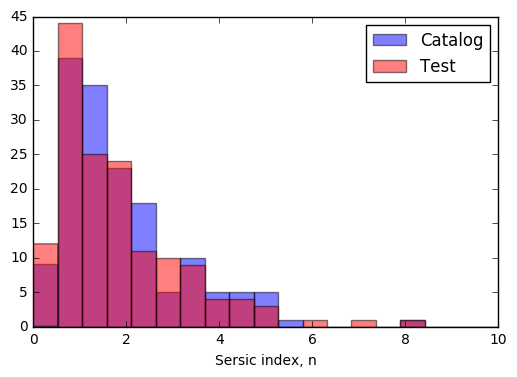

7.9837


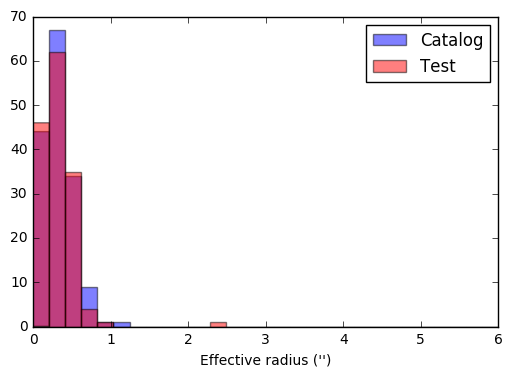

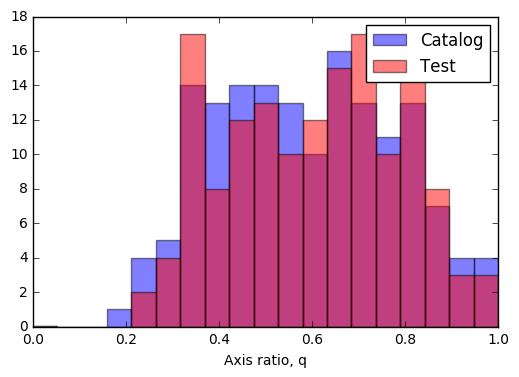

['ID_M' 'ra' 'dec' 're_M' 'ar' 'n_M' 'mag_M' 'sky' 'chi2nu' 'ErrorValue'
 'ID_C' 'IAU_designation' 'RA_x' 'DEC_x' 'APCOR' 'CFHT_uS_FLUX'
 'CFHT_uS_FLUXERR' 'CFHT_gS_FLUX' 'CFHT_gS_FLUXERR' 'CFHT_rS_FLUX'
 'CFHT_rS_FLUXERR' 'CFHT_iS_FLUX' 'CFHT_iS_FLUXERR' 'CFHT_zS_FLUX'
 'CFHT_zS_FLUXERR' 'Subaru_B_FLUX' 'Subaru_B_FLUXERR' 'Subaru_gp_FLUX'
 'Subaru_gp_FLUXERR' 'Subaru_V_FLUX' 'Subaru_V_FLUXERR' 'Subaru_rp_FLUX'
 'Subaru_rp_FLUXERR' 'Subaru_ip_FLUX' 'Subaru_ip_FLUXERR' 'Subaru_zp_FLUX'
 'Subaru_zp_FLUXERR' 'ACS_F606W_FLUX' 'ACS_F606W_FLUXERR' 'ACS_F814W_FLUX'
 'ACS_F814W_FLUXERR' 'WFC3_F125W_FLUX' 'WFC3_F125W_FLUXERR'
 'WFC3_F160W_FLUX' 'WFC3_F160W_FLUXERR' 'UltraVISTA_Y_FLUX'
 'UltraVISTA_Y_FLUXERR' 'UltraVISTA_J_FLUX' 'UltraVISTA_J_FLUXERR'
 'UltraVISTA_H_FLUX' 'UltraVISTA_H_FLUXERR' 'UltraVISTA_Ks_FLUX'
 'UltraVISTA_Ks_FLUXERR' 'IRAC_Ch1_FLUX' 'IRAC_Ch1_FLUXERR'
 'IRAC_Ch2_FLUX' 'IRAC_Ch2_FLUXERR' 'IRAC_Ch3_FLUX' 'IRAC_Ch3_FLUXERR'
 'IRAC_Ch4_FLUX' 'IRAC_Ch4_FLUXERR' 'NEWFIRM_J1_FLUX

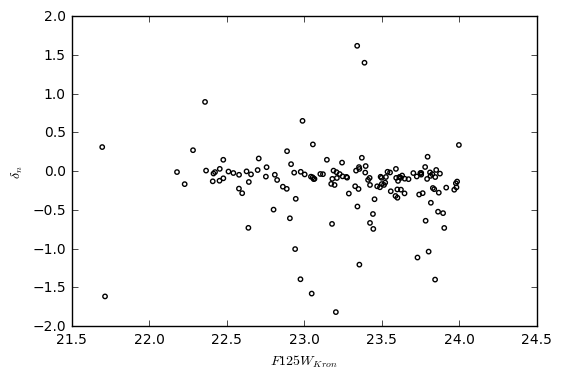

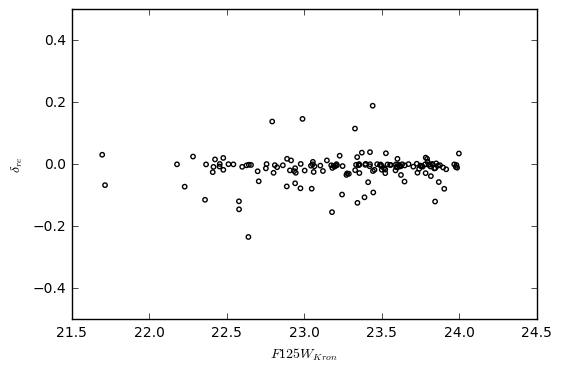

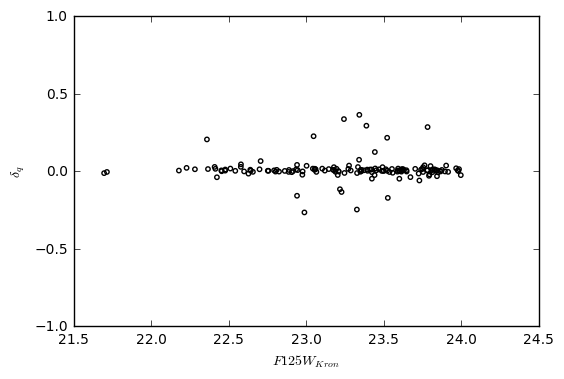

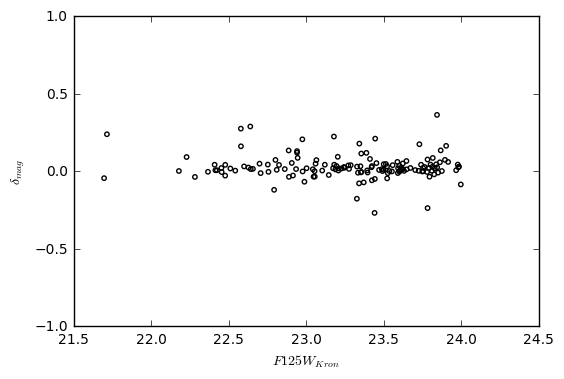

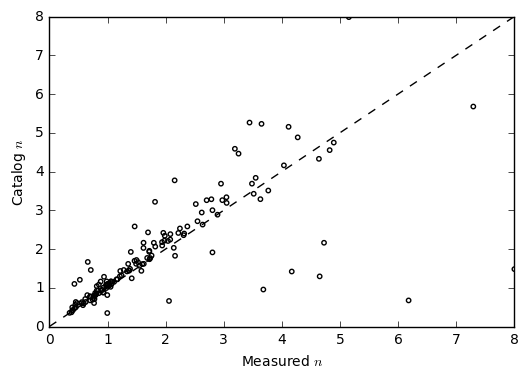

Mean abs dex difference between measured and catalog n: 0.0903777736903
Median abs dex difference between measured and catalog n: 0.0401146903100322
Mean abs diff between measured and catalog n: 0.437202013423
Median abs diff between measured and catalog n: 0.14670000000000005
Mean difference between measured and catalog n: -0.022755033557
Median difference between measured and catalog n: -0.08590000000000009
STD of difference between measured and catalog n: 0.983848808871
Median offset in delta(n)/n in dex: -0.1059838821166705
Scatter in in delta(n)/n in dex: 3.07236635281


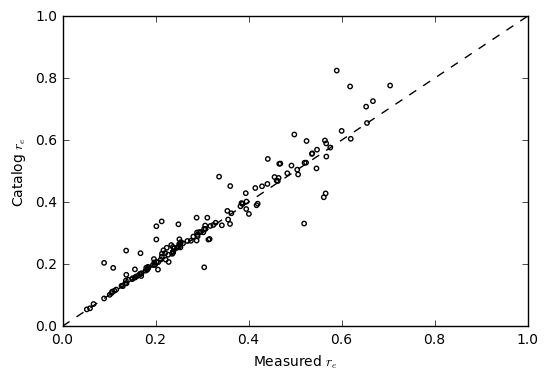

Mean offset between measured and cataloged re (percentage): -0.89
Mean abs offset between measured and cataloged re (percentage): 10.62
Median offset between measured and cataloged re (percentage): -2.28
Median abs offset between measured and cataloged re (percentage): 3.87
Mean abs dex difference between measured and catalog re: 0.0412691745829
Median abs dex difference between measured and catalog re: 0.017132826816136815
Mean abs diff between measured and catalog re: 0.0396076644295
Median abs diff between measured and catalog re: 0.011975999999999987
Mean difference between measured and catalog re: -0.00155284563758
Median difference between measured and catalog re: -0.005388000000000059


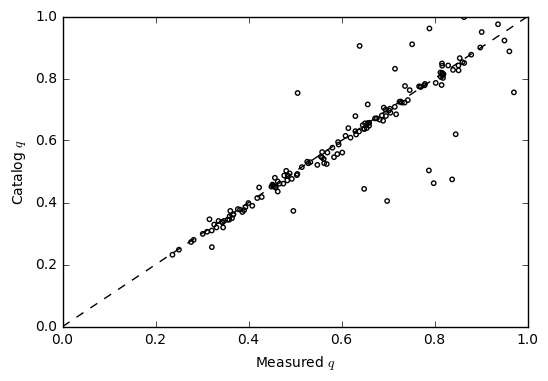

Mean dex difference between measured and catalog q: 0.0233851984748
Median dex difference between measured and catalog q: 0.007866141442035818
Mean abs dex diff between measured and catalog n: 0.0233851984748
Median abs dex diff between measured and catalog n: 0.007866141442035818
Mean dex difference between measured and catalog q: 0.00940567319954
Median dex difference between measured and catalog q: 0.004367210460068105


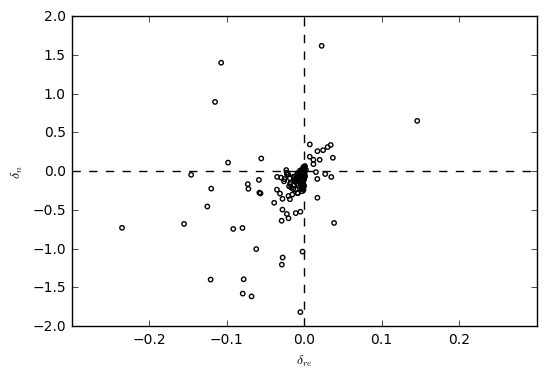

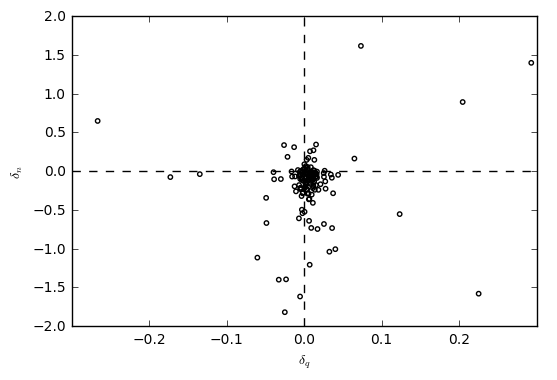

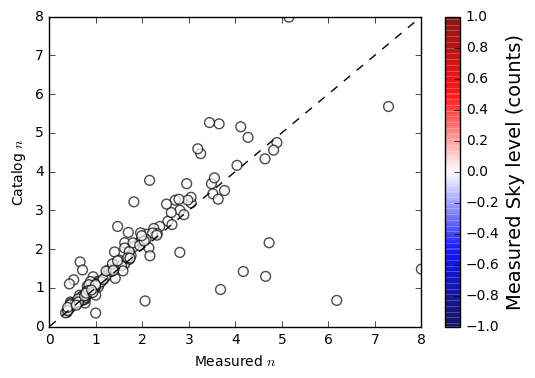

In [25]:
compare_df('results/'+save_name+'.csv',tdf,sky=True)

In [258]:
for i in tdf['NUMBER'][0:20]:
    print i
#     plot_by_ID(i,save_name = 'rmssigmameanexp_w100_NOPSF')
#     plot_by_ID(i,save_name = 'sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_20min_w60_CONSTR')
    plot_by_ID(i,save_name=save_name,cos_df=cos_df_highz)

150.05680800000002
ID: 150.05680800000002
ttdf[ID] 0      185
1      453
2      801
3      854
4      864
5      998
6     1359
7     1918
8     2003
9     2014
10    2093
11    2233
12    2405
13    2519
14    2522
...
141    24256
142    24304
143    24387
144    24408
145    24418
146    25394
147    25496
148    25553
149    26151
150    26272
151    27515
152    27569
153    27761
154    28036
155    28242
Name: ID, Length: 156, dtype: int64
Empty DataFrame
Columns: [ID, ra, dec, re, ar, n, mag, sky, chi2nu, ErrorValue]
Index: []
No model fit found. Plotting raw image from /cutout.fits
No cutout.fits file found...


IOError: [Errno 2] No such file or directory: '/data/emiln/XLSSU122/analysis/cosmos/galfit_results/150.05680800000002/data_cps.fits'

In [ ]:
# Make a figure of catalog value vs measured value and color points by measured sky value

In [40]:
cos_df[cos_df['NUMBER']==347]

,NUMBER,RA,DEC,f,mag,dmag,re,dre,n,dn,q,dq,pa,dpa,sn,X,Y
346,347,150.125061,2.182366,0,18.6633,0.003298,0.019338,0.00011,2.111,0.028812,0.4505,0.00498,-74.1111,0.632949,901.276,6876.498416,8084.075886


In [64]:
tdf = pd.read_csv('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_10min.csv')
fail_ids = tdf[tdf['re']<0]['ID']
print fail_ids.values

[  544  1377  1449  1897  2677  4119  4465  4720  4781  5693  6529  6771
  7214  8179  9045  9529 10228 10486 10927 11051 11170 11601 12033 12444
 12942 14450 14630 15707 18569 19396 20163 21454 22411 23512 24081 25869
 27670 27906 28777 28983 33946]


In [15]:
print len(new_df[new_df['ErrorValue']>0])
print len(new_df[new_df['re']<0])
print len(new_df[(new_df['ErrorValue']>1122) & (new_df['ErrorValue']<2000)])

188
84
45


In [ ]:
new_df[(new_df['ErrorValue']>1122) & (new_df['ErrorValue']<2000)]

In [42]:
print new_df['ErrorValue'].value_counts()

0      796
1       41
124      1
dtype: int64


        ID          ra       dec        re       ar        n      mag  \
0      347  150.125061  2.182366    0.4084   0.0786   3.5525  20.4344   
1      434  150.115204  2.182847    0.3000   0.0930   4.0490  18.7985   
2      543  150.083038  2.186648   10.1192   0.3139   1.0749  21.9779   
3      544  150.130371  2.185945    7.9754   0.4356   1.1610  21.3402   
4      561  150.079315  2.185860    9.5035   0.7075   1.3446  21.7382   
5      803  150.119278  2.187906   10.3040   0.8364   0.8707  21.9392   
6      836  150.151749  2.188684    9.5187   0.8017   0.7747  21.6280   
7      856  150.073822  2.189355    3.9434   0.7361   3.0909  22.1325   
8      886  150.118835  2.189954    4.5023   0.3628   2.3868  21.5200   
9      910  150.158203  2.190113    9.7235   0.7900   0.7053  21.7966   
10     944  150.146301  2.187830   11.9796   0.3372   3.2955  21.1145   
11     969  150.111603  2.187164   10.3747   0.5194   3.9006  21.0251   
12     980  150.168289  2.190455    0.3096   0.3715

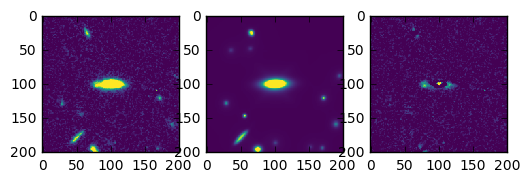

544
ID: 544
ttdf[ID] 0    543
1    544
2    561
3    803
Name: ID, dtype: int64
    ID          ra       dec      re     ar       n      mag     sky  \
1  544  150.130371  2.185945  8.7123  0.376  1.2765  21.2997  0.2775   

     chi2nu  ErrorValue  
1  0.733185           0  

 ***CATALOG PARAMS***
     NUMBER          RA       DEC  f      mag      dmag        re       dre  \
543     544  150.130371  2.185945  0  20.2375  0.004955  0.571914  0.002996   

         n        dn       q        dq       pa       dpa       sn  \
543  1.395  0.014848  0.3561  0.002878  84.6609  0.230404  590.901   

               X            Y  
543  6558.131558  8298.818279  


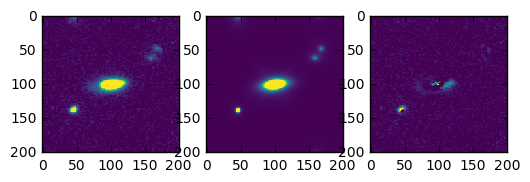

561
ID: 561
ttdf[ID] 0    543
1    544
2    561
3    803
Name: ID, dtype: int64
    ID          ra      dec      re      ar       n      mag     sky  \
2  561  150.079315  2.18586  9.1748  0.7186  1.2881  21.7617  0.3556   

     chi2nu  ErrorValue  
2  0.666187           0  

 ***CATALOG PARAMS***
     NUMBER          RA      DEC  f     mag      dmag        re       dre  \
560     561  150.079315  2.18586  0  20.536  0.009509  0.636768  0.007032   

          n        dn       q        dq       pa       dpa       sn  \
560  2.0473  0.040846  0.8388  0.005346 -72.7879  0.429146  328.294   

               X           Y  
560  9619.262305  8293.74167  


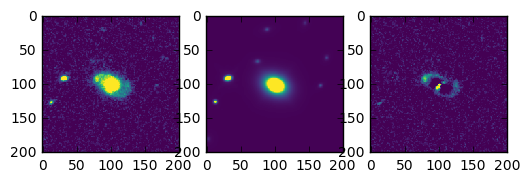

803
ID: 803
ttdf[ID] 0    543
1    544
2    561
3    803
Name: ID, dtype: int64
    ID          ra       dec       re      ar       n      mag     sky  \
3  803  150.119278  2.187906  10.3357  0.8585  0.8559  21.9362  0.4415   

     chi2nu  ErrorValue  
3  0.836791           0  

 ***CATALOG PARAMS***
     NUMBER          RA       DEC  f     mag      dmag        re       dre  \
802     803  150.119278  2.187906  0  20.656  0.010884  0.776682  0.008842   

          n        dn      q        dq      pa       dpa       sn  \
802  1.3614  0.028495  0.845  0.005745 -3.2507  0.422511  281.777   

               X            Y  
802  7223.227357  8416.474498  


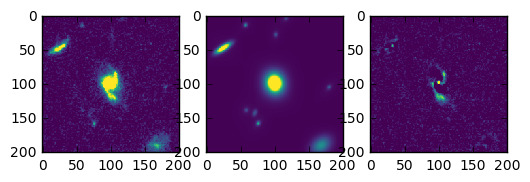

In [17]:
# for i in new_df[new_df['ErrorValue']!=0]['ID']:
#     plot_by_ID(i,save_name = 'rmssigmameanexp_w100_400PSF_PARALLEL')
#     plot_by_ID(i,save_name = 'rmssigmameanexp_w100_NOPSF')
#     plot_by_ID(i,save_name = 'rmssigmameanexp_w100_NOPSF')

# test_df = new_df[new_df['re']<0]['ID']
# test_df = new_df[new_df['n']>7.5]['ID']

tdf = pd.read_csv('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_20min_w60_CONSTR.csv')
print tdf

# test_df = tdf[tdf['ar']>0.95]['ID']
test_df = tdf[tdf['re']<0]['ID']
# print len(test_df)

test_df = new_df['ID']
# test_df = cos_df[cos_df['n']<0.4]['NUMBER']

for i in test_df:
    print i
#     plot_by_ID(i,save_name = 'rmssigmameanexp_w100_NOPSF')
#     plot_by_ID(i,save_name = 'sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_20min_w60_CONSTR')
    plot_by_ID(i,save_name = save_name)

    ID          ra       dec      re      ar      n      mag    chi2nu  \
0  544  150.130371  2.185945  7.9754  0.4356  1.161  21.3402  1.100161   

   ErrorValue  
0           0  

 ***CATALOG PARAMS***
     NUMBER          RA       DEC  f      mag      dmag        re       dre  \
543     544  150.130371  2.185945  0  20.2375  0.004955  0.571914  0.002996   

         n        dn       q        dq       pa       dpa       sn  \
543  1.395  0.014848  0.3561  0.002878  84.6609  0.230404  590.901   

               X            Y  
543  6558.131558  8298.818279  


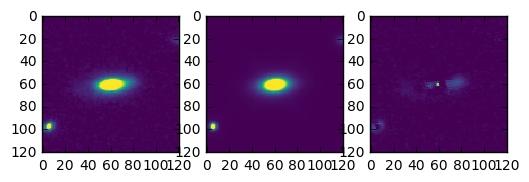

In [21]:
plot_by_ID(544, save_name = save_name)

    ID          ra       dec      re      ar       n    mag    chi2nu  \
8  886  150.118835  2.189954  4.5023  0.3628  2.3868  21.52  0.765764   

   ErrorValue  
8           0  

 ***CATALOG PARAMS***
     NUMBER          RA       DEC  f      mag     dmag        re       dre  \
885     886  150.118835  2.189954  0  20.4608  0.00709  0.275172  0.003144   

          n        dn       q        dq       pa       dpa       sn  \
885  3.0431  0.068567  0.3509  0.007989 -62.9356  0.867721  463.785   

               X           Y  
885  7249.788183  8539.35443  


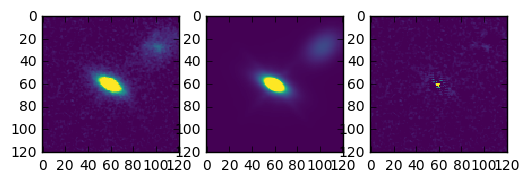

In [14]:
plot_by_ID(886, save_name = save_name)
# plot_by_ID(886, save_name = 'rmssigmameanexp_w100_400PSF_TEST')
# plot_by_ID(886, save_name = 'rmssigmameanexp_w100_SUBSAMPLEDPSF_TEST')

In [17]:
# Galfit mag test
# https://users.obs.carnegiescience.edu/peng/work/galfit/TFAQ.html
zp=21.1
mag = -2.5 * np.log10((147176 - 1.5*2650)/82916)+zp
print mag

20.506730730312977


------------------------
## Run GALFIT

In [ ]:
# Mag<21 sources, width=50 (radius) = 3'', no psf
run_galfit_cosmos(cos_df,cos_df_OG,zp=26,width=50,use_psf=False,\
                  sigma_file='/sigma_meanexp_cutout.fits',\
                  save_name='rmssigmameanexp_w100_NOPSF')

In [ ]:
# Mag<21 sources, width=50 (radius) = 3'', original tinytim psf
run_galfit_cosmos(cos_df,cos_df_OG,zp=26,width=50,use_psf=True,\
                  psf_file='tinytim_psf.fits',\
                  sigma_file='/sigma_meanexp_cutout.fits',\
                  save_name='rmssigmameanexp_w100_TTPSF')

In [ ]:
# Mag<21 sources, width=50 (radius) = 3'', new tinytim PSF from download
run_galfit_cosmos(cos_df,cos_df_OG,zp=26,width=95,use_psf=True,\
                  psf_file='f125w_400_400_6arcsec_psf.fits',\
                  sigma_file='/sigma_meanexp_cutout.fits',\
                  save_name='rmssigmameanexp_w190_400PSF')

In [ ]:
# run_galfit_cosmos??
gf.rungalfit??

In [ ]:
plot_by_ID(26368,save_name='rmssigmameanexp_w100_nopsf')
plot_by_ID(26368,save_name='rmssigmameanexp_w100_400PSF')
save_name = 'rmssigmameanexp_w300_400PSF_PARALLEL_21_mag_23'


---------------------------------
## Compare to catalog

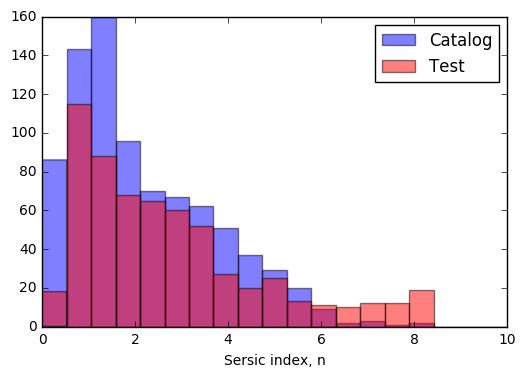

7.976


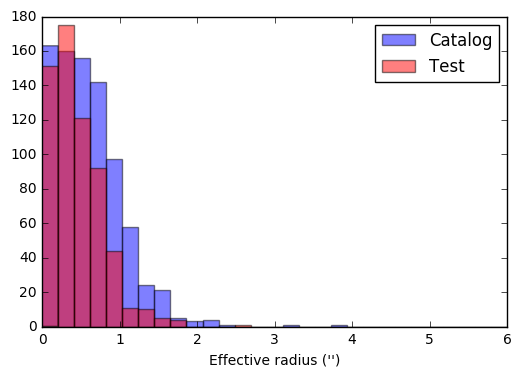

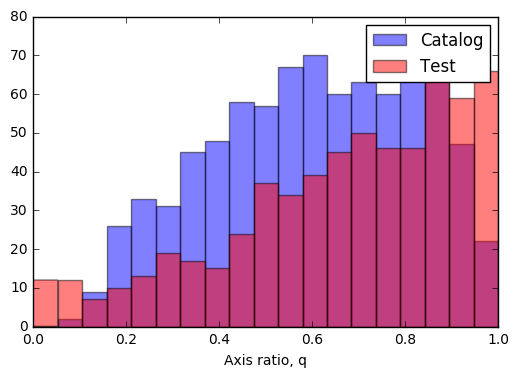

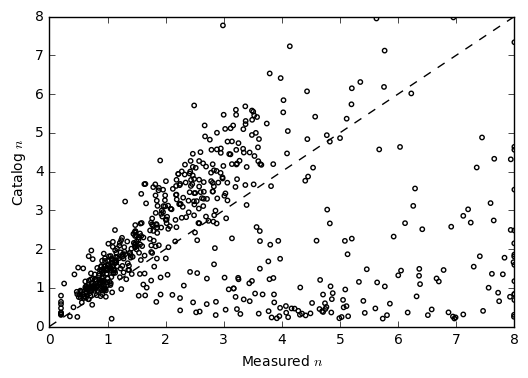

Mean abs dex difference between measured and catalog n: 0.303990661883
Median abs dex difference between measured and catalog n: 0.1855383326262676
Mean abs diff between measured and catalog n: 0.303990661883
Median abs diff between measured and catalog n: 0.1855383326262676
Mean difference between measured and catalog n: 0.0824044384677
Median difference between measured and catalog n: -0.10585094285769081


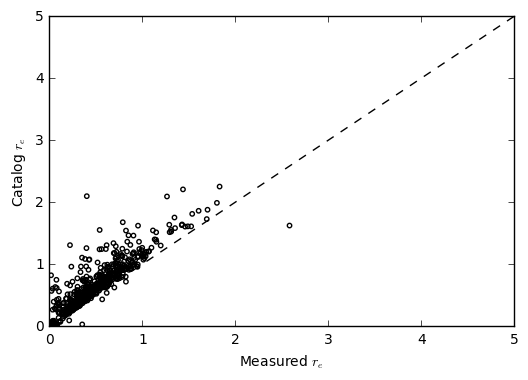

Mean abs dex difference between measured and catalog re: 0.163853318308
Median abs dex difference between measured and catalog re: 0.11239256693053279
Mean abs diff between measured and catalog n: 0.163853318308
Median abs diff between measured and catalog n: 0.11239256693053279
Mean difference between measured and catalog re: -0.142703088864
Median difference between measured and catalog re: -0.10332862898872891


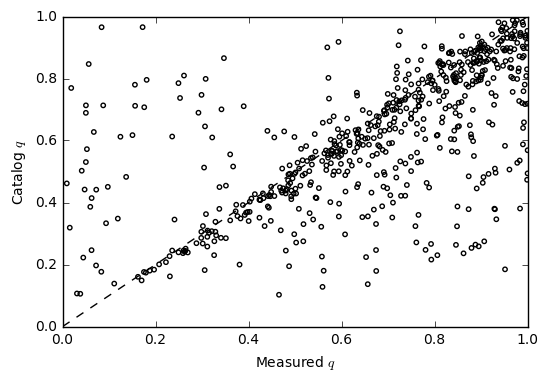

Mean dex difference between measured and catalog q: 0.131357060183
Median dex difference between measured and catalog q: 0.041938167099608153
Mean abs diff between measured and catalog n: 0.131357060183
Median abs diff between measured and catalog n: 0.041938167099608153
Mean difference between measured and catalog q: 0.0114729468347
Median difference between measured and catalog q: 0.023545891323676474


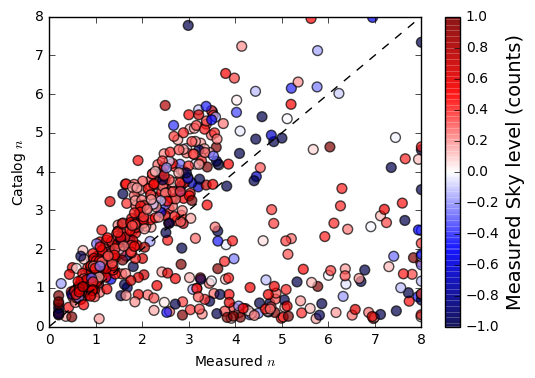

In [48]:
compare_df('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_60min_w100_CONSTR_100conv.csv',cos_df,sky=True)

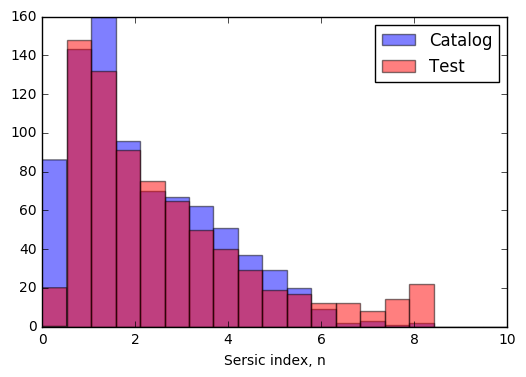

7.976


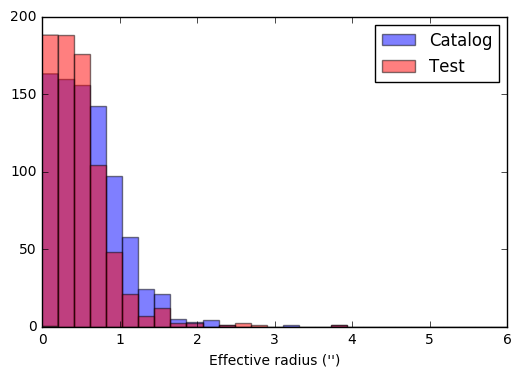

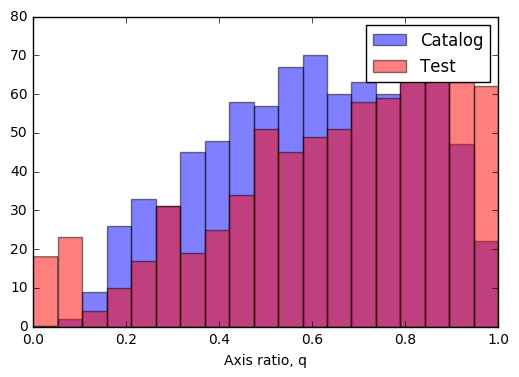

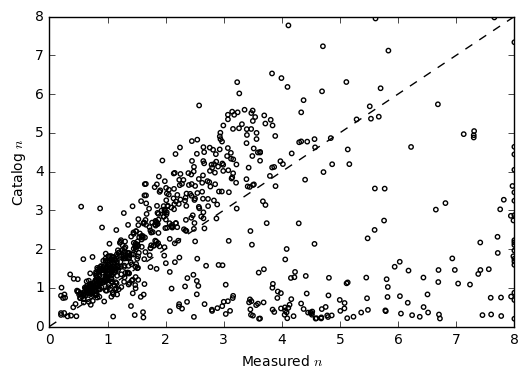

Mean abs dex difference between measured and catalog n: 0.2904762822
Median abs dex difference between measured and catalog n: 0.17445222748558398
Mean abs diff between measured and catalog n: 0.2904762822
Median abs diff between measured and catalog n: 0.17445222748558398
Mean difference between measured and catalog n: 0.0731476215675
Median difference between measured and catalog n: -0.09940844633103962


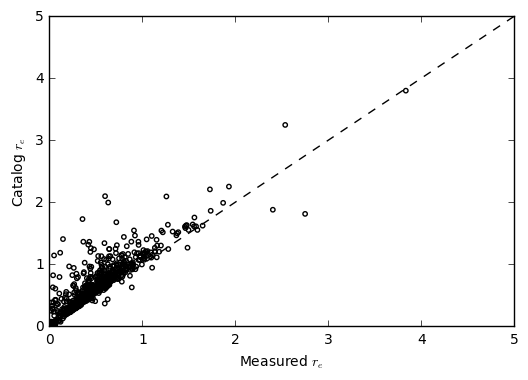

Mean abs dex difference between measured and catalog re: 0.151889584486
Median abs dex difference between measured and catalog re: 0.09649175496080964
Mean abs diff between measured and catalog n: 0.151889584486
Median abs diff between measured and catalog n: 0.09649175496080964
Mean difference between measured and catalog re: -0.140307761515
Median difference between measured and catalog re: -0.09308688895739338


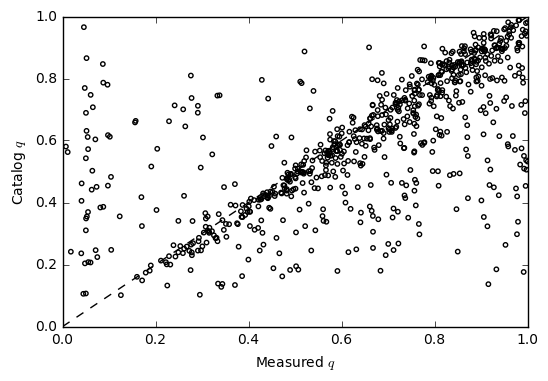

Mean dex difference between measured and catalog q: 0.132550022653
Median dex difference between measured and catalog q: 0.036438276072575576
Mean abs diff between measured and catalog n: 0.132550022653
Median abs diff between measured and catalog n: 0.036438276072575576
Mean difference between measured and catalog q: -0.000299084835172
Median difference between measured and catalog q: 0.018733679016347732


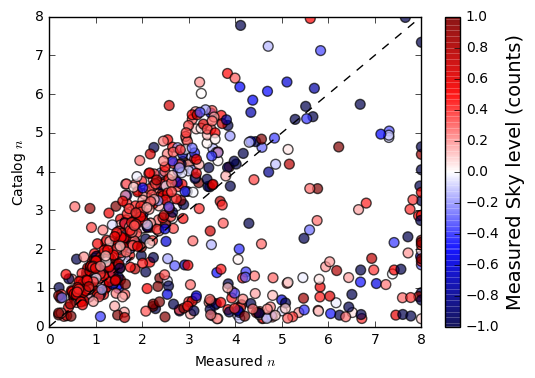

In [49]:
compare_df('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_30min_w80_CONSTR_100conv.csv',cos_df,sky=True)

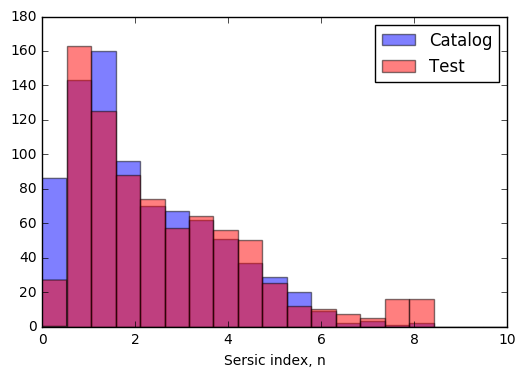

7.976


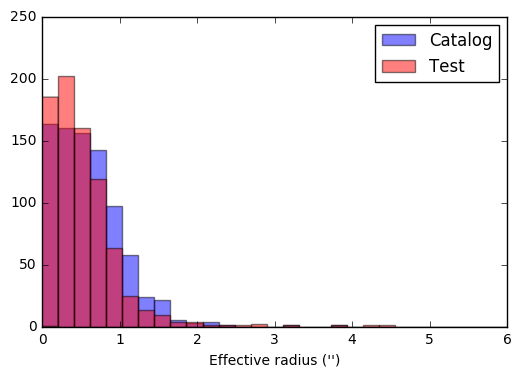

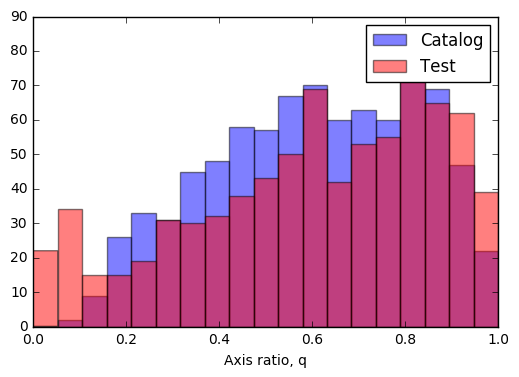

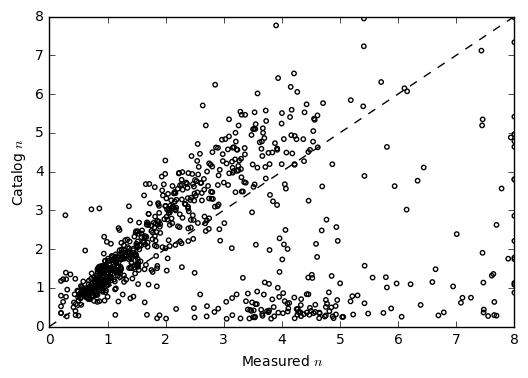

Mean abs dex difference between measured and catalog n: 0.292405689373
Median abs dex difference between measured and catalog n: 0.16700542175075517
Mean abs diff between measured and catalog n: 0.292405689373
Median abs diff between measured and catalog n: 0.16700542175075517
Mean difference between measured and catalog n: 0.0775487260282
Median difference between measured and catalog n: -0.09982099491183653


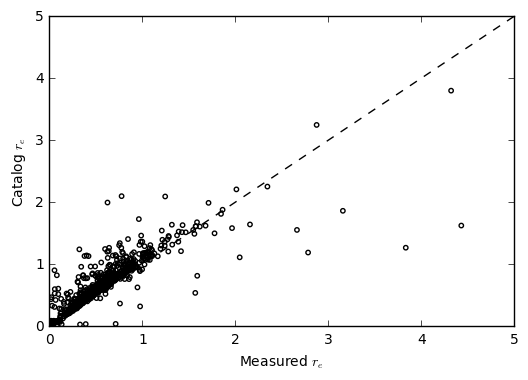

Mean abs dex difference between measured and catalog re: 0.131502107065
Median abs dex difference between measured and catalog re: 0.07030873766263712
Mean abs diff between measured and catalog n: 0.131502107065
Median abs diff between measured and catalog n: 0.07030873766263712
Mean difference between measured and catalog re: -0.100755549009
Median difference between measured and catalog re: -0.06312516977019494


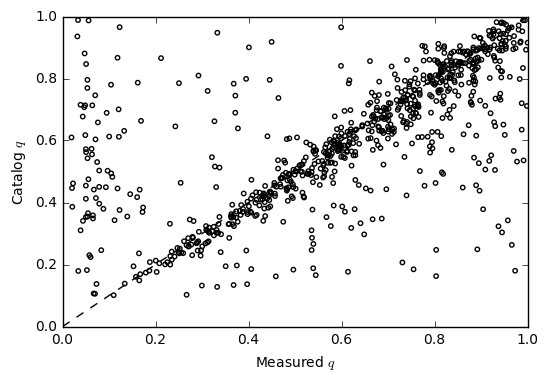

Mean dex difference between measured and catalog q: 0.138627701391
Median dex difference between measured and catalog q: 0.03143510135960548
Mean abs diff between measured and catalog n: 0.138627701391
Median abs diff between measured and catalog n: 0.03143510135960548
Mean difference between measured and catalog q: -0.0456082652859
Median difference between measured and catalog q: 0.010340833338218836


KeyError: 'sky'

In [37]:
compare_df('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_20min_w60_CONSTR.csv',cos_df)

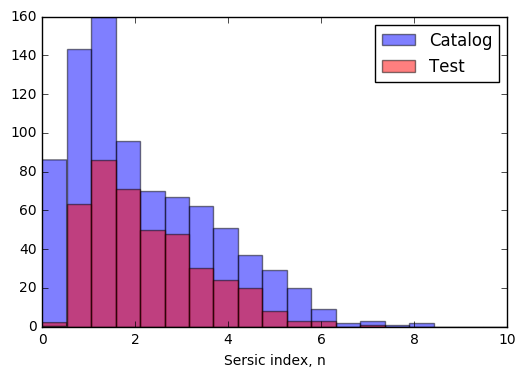

7.976


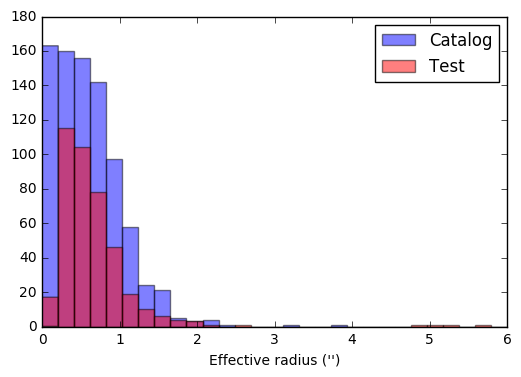

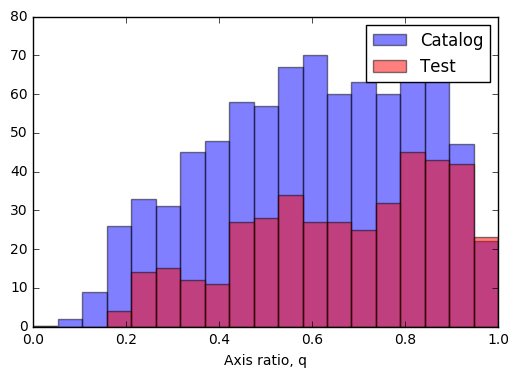

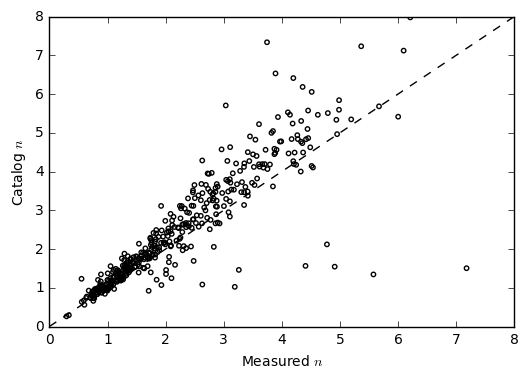

Mean abs dex difference between measured and catalog n: 0.075333639971
Median abs dex difference between measured and catalog n: 0.058707740576183026
Mean abs diff between measured and catalog n: 0.075333639971
Median abs diff between measured and catalog n: 0.058707740576183026
Mean difference between measured and catalog n: -0.0401599970265
Median difference between measured and catalog n: -0.0515957968823435
STD of difference between measured and catalog n: 0.10101200097
Median offset in delta(n)/n in dex: -0.13534992664497159
Scatter in in delta(n)/n in dex: 3.02010143632


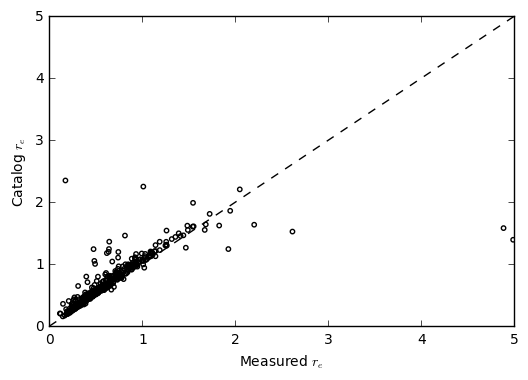

Mean abs dex difference between measured and catalog re: 0.0668704632239
Median abs dex difference between measured and catalog re: 0.03843505722740537
Mean abs diff between measured and catalog n: 0.0668704632239
Median abs diff between measured and catalog n: 0.03843505722740537
Mean difference between measured and catalog re: -0.0478042575797
Median difference between measured and catalog re: -0.03645637910886429


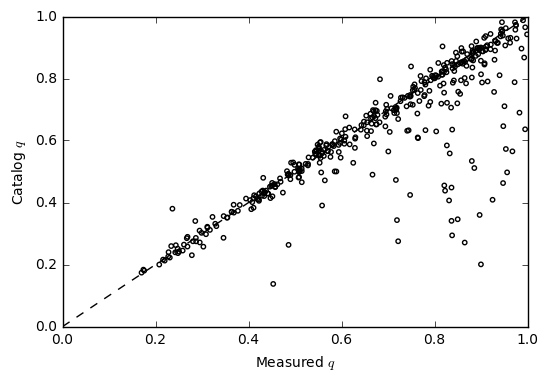

Mean dex difference between measured and catalog q: 0.0385405909678
Median dex difference between measured and catalog q: 0.01195906172697564
Mean abs diff between measured and catalog n: 0.0385405909678
Median abs diff between measured and catalog n: 0.01195906172697564
Mean difference between measured and catalog q: 0.0276863920747
Median difference between measured and catalog q: 0.0028780389084305247


In [19]:
compare_df('COSMOS_test_galfit_results_rmssigmameanexp_w190_400PSF.csv',cos_df)

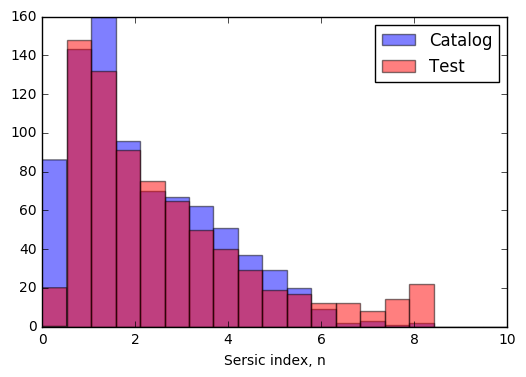

7.976


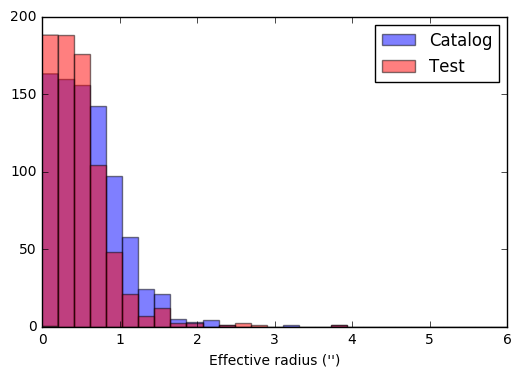

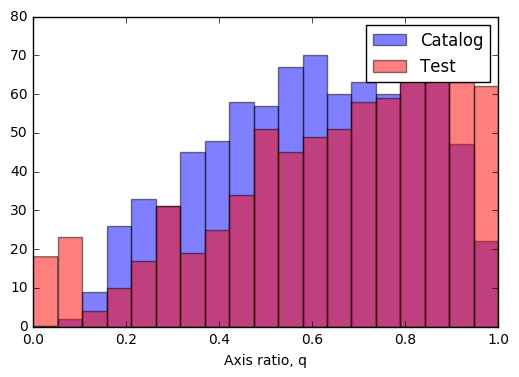

In [18]:
compare_df('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_30min_w80_CONSTR_100conv.csv',cos_df)

In [ ]:
compare_df('COSMOS_test_galfit_results_rmssigmameanexp_w100_400PSF.csv',cos_df)

In [ ]:
compare_df('COSMOS_test_galfit_results_rmssigmameanexp_w100_TTPSF.csv',cos_df)

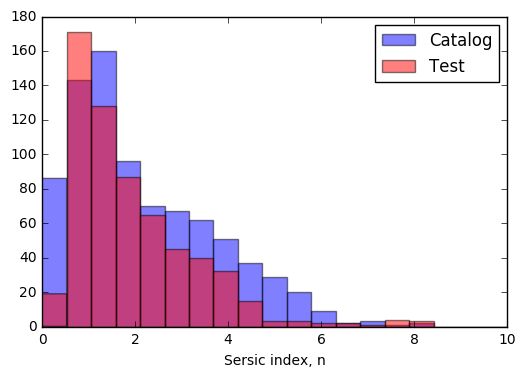

7.976


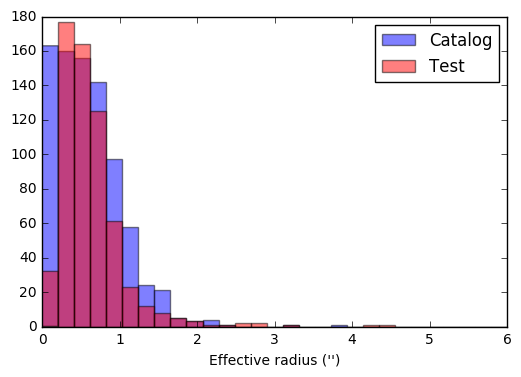

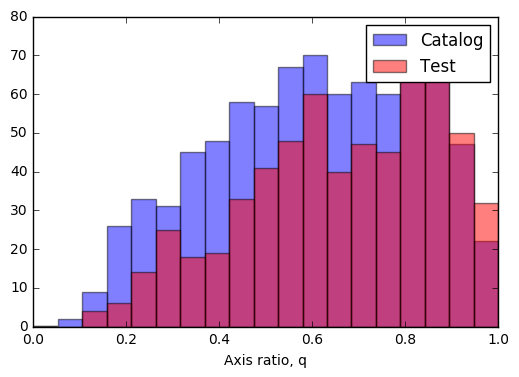

In [37]:
compare_df('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF.csv',cos_df)

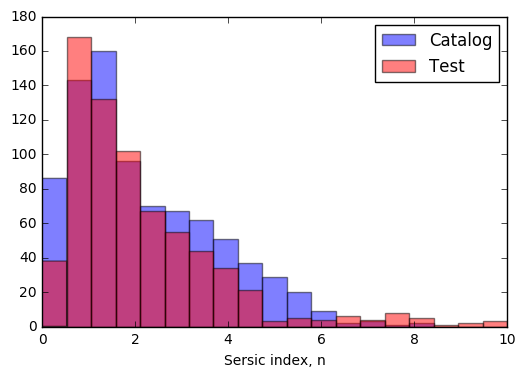

7.976


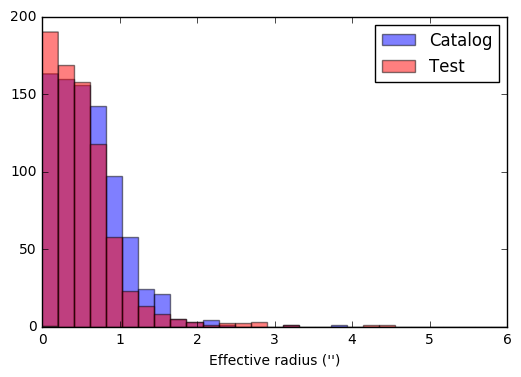

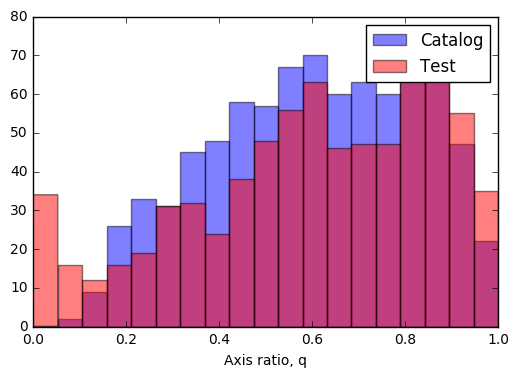

In [15]:
compare_df('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED.csv',cos_df)

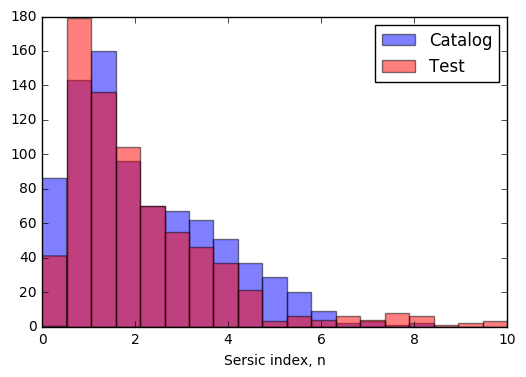

7.976


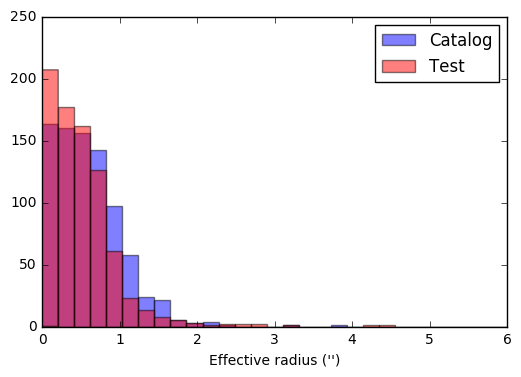

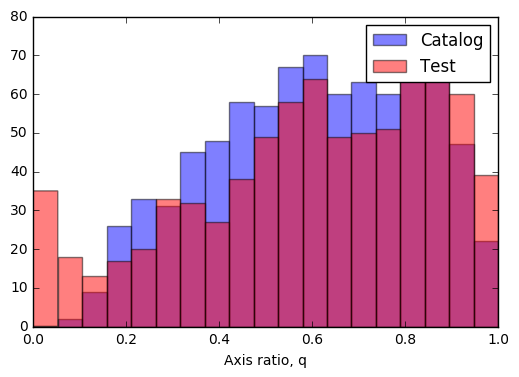

In [15]:
compare_df('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_10min.csv',cos_df)

       ID          ra       dec         re       ar        n      mag  \
0     544  150.130371  2.185945   9.380700   0.3592   1.2182  21.2530   
1    1377  150.053131  2.195382   0.010100   0.1415  20.0000  21.3452   
2    1449  150.198044  2.194189  17.111700   0.7635   1.0853  21.7294   
3    1897  150.055664  2.200143  23.461000   0.2338   1.0513  20.4948   
4    2677  150.057220  2.205933   7.425400   0.9121   4.9806  18.7990   
5    4119  150.089951  2.225190  10.357600   0.8288   0.5788  21.8336   
6    4465  150.202469  2.228052   6.562300   0.4744   2.1634  20.3410   
7    4720  150.101700  2.232877 -99.000000 -99.0000 -99.0000 -99.0000   
8    4781  150.071075  2.233042   7.465700   0.8985   1.3632  20.8424   
9    5693  150.193024  2.244551  14.446500   0.3735   0.7129  21.7809   
10   6529  150.095428  2.255140   0.004307   0.0532   1.3222  20.4308   
11   6771  150.130325  2.259626   6.364300   0.4747   1.5466  21.9808   
12   7214  150.169418  2.263689   0.014600   0.0465

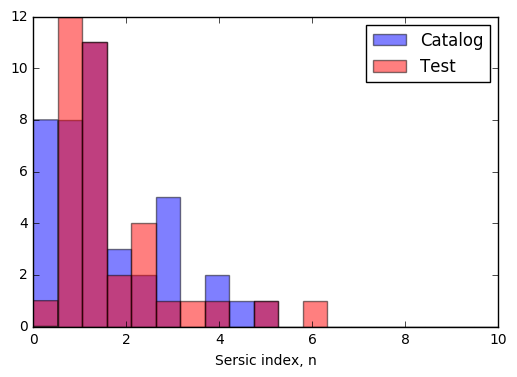

5.1889


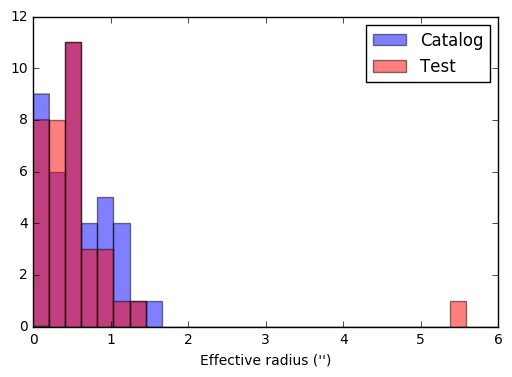

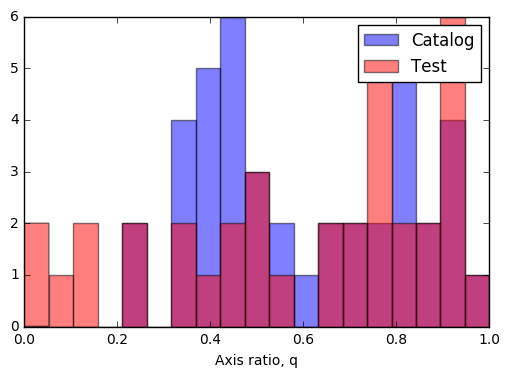

In [63]:
tdf = pd.read_csv('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_10min_FAILURE_RERUNS_w50.csv')
print tdf

compare_df('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_10min_FAILURE_RERUNS_w50.csv',cos_df[cos_df['NUMBER'].isin(tdf['ID'].values)])

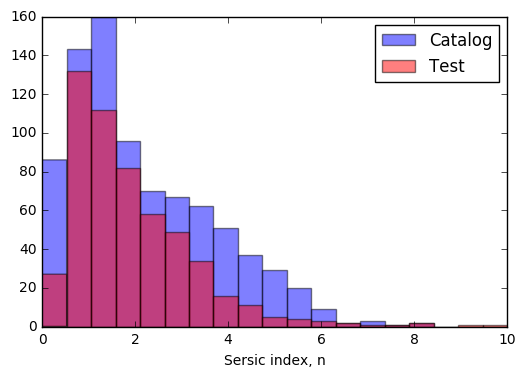

7.976


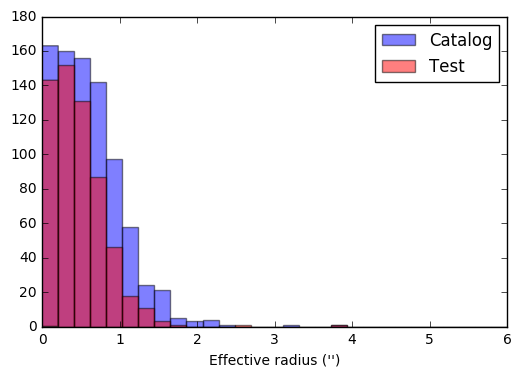

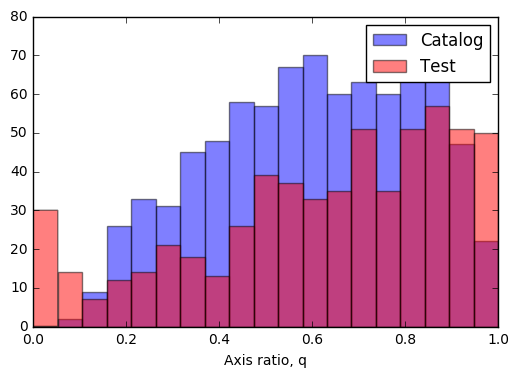

In [18]:
compare_df('COSMOS_test_galfit_results_sigma_meanexp_counts_CDKinterp_PSF_EVFIXED_20min_w100.csv',cos_df)

In [ ]:
cos_df[cos_df['NUMBER']==2619]

In [ ]:
len(cos_df)
cos_df.columns.values

In [ ]:
# What is going on with the objects that I find a large axis ratio for but catalog AR is small
# tdf = pd.read_csv('COSMOS_test_galfit_results_rmssigmameanexp_w100_nopsf.csv')
save_name = 'rmssigmameanexp_w100_400PSF'


tdf = pd.read_csv('COSMOS_test_galfit_results_'+save_name+'.csv')
print "Len(tdf):", len(tdf)
tdf = tdf[tdf['n']!=-99]
print "Len(tdf != -99)", len(tdf),'\n'
hq_tdf = tdf[tdf['ar']>0.95]

plt.hist(hq_tdf['re']*0.06,bins=np.linspace(0,6,30), alpha=0.5,color='blue')

print "len(tdf[tdf['ar']>0.95]) = ", len(hq_tdf)
tcos_df = cos_df[cos_df['NUMBER'].isin(hq_tdf['ID'])]
# print tcos_df['NUMBER']
# print hq_tdf['ID']
print len(tcos_df)
# print len(hq_tdf)
tmdf = hq_tdf.merge(tcos_df,left_on='ID',right_on='NUMBER',how='inner')
print "len(tmdf):", len(tmdf)
tdf = tmdf[(tmdf['ar']-tmdf['q'])>0.1]
print len(tdf)
# for i,r in hq_tdf[0:5].iterrows():
#     plot_by_ID(int(r['ID']))
for i,r in tdf[0:20].iterrows():
    print "Catalog q:", r.q
    print "Measured q:", r.ar
    plot_by_ID(int(r['ID']), save_name=save_name)
    plot_by_ID(int(r['ID']), save_name='rmssigmameanexp_w100_nopsf')

In [ ]:
# What is going on with the objects that I find a small n for but catalog n is large
# tdf = pd.read_csv('COSMOS_test_galfit_results_rmssigmameanexp_w100_nopsf.csv')
print len(cos_df)
ln_cdf = cos_df[cos_df['n']<0.5]
print "len(cos_df[cos_df['n']<0.5]) = ", len(ln_cdf)

tdf = pd.read_csv('COSMOS_test_galfit_results_rmssigmameanexp_w100_400PSF.csv')
print "Len(tdf):", len(tdf)
# tdf = tdf[tdf['n']!=-99]
print "Len(tdf != -99)", len(tdf),'\n'
print tdf.columns.values
# print tdf['n']

t_tdf = tdf[tdf['ID'].isin(ln_cdf['NUMBER'])]
# print tcos_df['NUMBER']
# print hq_tdf['ID']
print "len(t_tdf):", len(t_tdf)
# print len(hq_tdf)
tmdf = t_tdf.merge(ln_cdf,left_on='ID',right_on='NUMBER',how='inner',suffixes=('_TEST','_CAT'))
print "len(tmdf):", len(tmdf)
# print tmdf.columns.values
# tdf = tmdf[abs(tmdf['n_TEST']-tmdf['n_CAT'])>0.1]
tdf = tmdf
print len(tdf)
# for i,r in hq_tdf[0:5].iterrows():
#     plot_by_ID(int(r['ID']))
for i,r in tdf[0:20].iterrows():
    print "Catalog n:", r.n_CAT
    print "Measured n:", r.n_TEST
    plot_by_ID(int(r['ID']))

In [ ]:
# Load fits and compare to published catalog
df2 = pd.read_csv('COSMOS_test_galfit_results.csv')
len(df2[df2['n']==-99])
df = df2[df2['n']!=-99]

plt.hist(cos_df['n'],bins=np.linspace(0,10,20),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['n'],bins=np.linspace(0,10,20), alpha=0.5,color='red', label='Test')
plt.xlabel('Sersic index, n')
plt.legend()
plt.show()
print np.max(cos_df['n'])

plt.hist(cos_df['re'],bins=np.linspace(0,6,30),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['re']*0.06,bins=np.linspace(0,6,30), alpha=0.5,color='red', label='Test')
plt.xlabel('Effective radius (\'\')')
plt.legend()
plt.show()

plt.hist(cos_df['q'],bins=np.linspace(0,1,20),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['ar'],bins=np.linspace(0,1,20), alpha=0.5,color='red', label='Test')
plt.xlabel('Axis ratio, q')
plt.legend()
plt.show()

In [ ]:
# Load fits and compare to published catalog
df2 = pd.read_csv('COSMOS_test_galfit_results_whtsigmameanexp_w100.csv')
len(df2[df2['n']==-99])
df = df2[df2['n']!=-99]

plt.hist(cos_df['n'],bins=np.linspace(0,10,20),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['n'],bins=np.linspace(0,10,20), alpha=0.5,color='red', label='Test')
plt.xlabel('Sersic index, n')
plt.legend()
plt.show()
print np.max(cos_df['n'])

plt.hist(cos_df['re'],bins=np.linspace(0,6,30),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['re']*0.06,bins=np.linspace(0,6,30), alpha=0.5,color='red', label='Test')
plt.xlabel('Effective radius (\'\')')
plt.legend()
plt.show()

plt.hist(cos_df['q'],bins=np.linspace(0,1,20),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['ar'],bins=np.linspace(0,1,20), alpha=0.5,color='red', label='Test')
plt.xlabel('Effective radius (\'\')')
plt.legend()
plt.show()

In [ ]:
# Load fits and compare to published catalog
df2 = pd.read_csv('COSMOS_test_galfit_results_whtsigmameanexp_w180.csv')
len(df2[df2['n']==-99])
df = df2[df2['n']!=-99]

plt.hist(cos_df['n'],bins=np.linspace(0,10,20),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['n'],bins=np.linspace(0,10,20), alpha=0.5,color='red', label='Test')
plt.xlabel('Sersic index, n')
plt.legend()
plt.show()
print np.max(cos_df['n'])

plt.hist(cos_df['re'],bins=np.linspace(0,6,30),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['re']*0.06,bins=np.linspace(0,6,30), alpha=0.5,color='red', label='Test')
plt.xlabel('Effective radius (\'\')')
plt.legend()
plt.show()

plt.hist(cos_df['q'],bins=np.linspace(0,1,20),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['ar'],bins=np.linspace(0,1,20), alpha=0.5,color='red', label='Test')
plt.xlabel('Axis ratio, q')
plt.legend()
plt.show()

In [ ]:
# Load fits and compare to published catalog
df2 = pd.read_csv('COSMOS_test_galfit_results_rmssigmameanexp_w180.csv')
len(df2[df2['n']==-99])
df = df2[df2['n']!=-99]

plt.hist(cos_df['n'],bins=np.linspace(0,10,20),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['n'],bins=np.linspace(0,10,20), alpha=0.5,color='red', label='Test')
plt.xlabel('Sersic index, n')
plt.legend()
plt.show()
print np.max(cos_df['n'])

plt.hist(cos_df['re'],bins=np.linspace(0,6,30),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['re']*0.06,bins=np.linspace(0,6,30), alpha=0.5,color='red', label='Test')
plt.xlabel('Effective radius (\'\')')
plt.legend()
plt.show()

plt.hist(cos_df['q'],bins=np.linspace(0,1,20),alpha=0.5,color='blue', label='Catalog')
plt.hist(df['ar'],bins=np.linspace(0,1,20), alpha=0.5,color='red', label='Test')
plt.xlabel('Axis ratio, q')
plt.legend()
plt.show()

Use the RMS + CPS for each postage stamp
Use the CPS*(AVERAGE EXPOSURE IN EXP MAP OF CUTOUT)
Compare the two

Make sure RMS map has poisson counts from sources included

Might need to divide RMS by exposure time if RMS is in counts, not CPS

Download bad pixel and implement and mask.